In [20]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import functools
from time import time

from astropy.table import Table, vstack, Column

import numpy as np 
import emcee

import scipy.linalg
import scipy.ndimage
import scipy.optimize
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.asap_data_io import *
from asap.asap_model_setup import *
from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 
from asap.um_model_plot import *
from asap.full_mass_profile_model import *
from asap.asap_mass_model import * 

from asap.lts_planefit import lts_planefit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import hsc_massive
from hsc_massive import \
    s16a_path, \
    mass_function, \
    weak_lensing, \
    sample_selection, \
    catalog_summary, \
    plotting

#envir = s16a_path.set_env(version='astro5')
envir = s16a_path.set_env(version='kungpao')

### Load in the model and data

In [3]:
config_file = 'test/asap_smdpl_mmax_m10_frac4_new_2.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

print(cfg['model_type'])

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: None
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 

#### Catalog of HSC galaxies

In [4]:
obs_mass = obs_data['obs_mass']

#### Realization of best-fit model

In [5]:
um_mock = um_data['um_mock']

In [6]:
(frac4a_result_samples, 
 frac4a_result_chains, 
 frac4a_result_lnprob, 
 frac4a_result_best, _, _) = mcmc_load_results(
    'test/asap_smdpl_mmax_m10_frac4_new_2_run.npz')

print(np.nanmax(frac4a_result_lnprob), frac4a_result_best)

(-170.754046867338, array([ 5.86371033e-01,  3.91320425e+00, -7.16588687e-05,  4.04260202e-02,
        5.78346450e-01, -2.13826456e-01,  4.79656831e-02]))


In [7]:
frac4a_model_prob = asap_predict_model_prob(frac4a_result_best, cfg, 
                                            obs_data, um_data, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_prob, logms_tot_mod_prob, 
 logms_halo_mod_prob, mask_tot_prob) = frac4a_model_prob

In [11]:
um_table = Table(um_mock)

um_table.add_column(Column(data=logms_inn_mod_all_4, name='logms_inn_mod'))
um_table.add_column(Column(data=logms_tot_mod_all_4, name='logms_tot_mod'))

um_table.write('/Users/song/Downloads/um_model.fits', format='fits', overwrite=True)

In [9]:
frac4a_model = asap_predict_model(frac4a_result_best, cfg, 
                                  obs_data, um_data, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all_1, logms_tot_mod_all_1, 
 logms_halo_mod_all_1, mask_tot_1) = frac4a_model

frac4a_model = asap_predict_model(frac4a_result_best, cfg, 
                                  obs_data, um_data, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all_2, logms_tot_mod_all_2, 
 logms_halo_mod_all_2, mask_tot_2) = frac4a_model

frac4a_model = asap_predict_model(frac4a_result_best, cfg, 
                                  obs_data, um_data, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all_3, logms_tot_mod_all_3, 
 logms_halo_mod_all_3, mask_tot_3) = frac4a_model

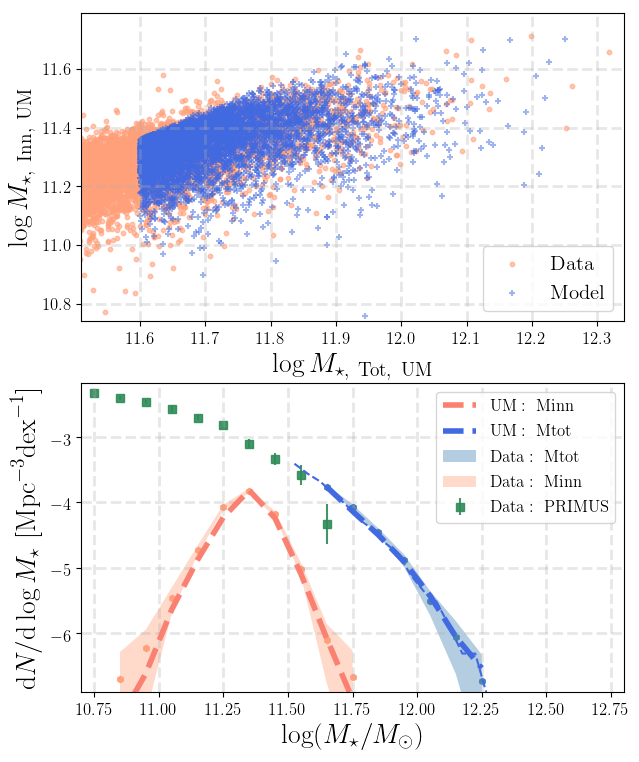

In [21]:
frac4a_model = asap_predict_model(frac4a_result_best, cfg, 
                                  obs_data, um_data, show_smf=True, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all_4, logms_tot_mod_all_4, 
 logms_halo_mod_all_4, mask_tot_4) = frac4a_model

### Using KD-Tree to assign halo mass to HSC galaxies

In [12]:
logms_inn_mod = np.concatenate((logms_inn_mod_all_1, logms_inn_mod_all_2,
                                logms_inn_mod_all_3, logms_inn_mod_all_4))

logms_tot_mod = np.concatenate((logms_tot_mod_all_1, logms_tot_mod_all_2,
                                logms_tot_mod_all_3, logms_tot_mod_all_4))

mask_tot = np.concatenate((mask_tot_1, mask_tot_2, mask_tot_3, mask_tot_4))

um_mock_stack = np.array(vstack([Table(um_mock), Table(um_mock), Table(um_mock), Table(um_mock)]))

In [13]:
um_mass = np.stack((logms_inn_mod, logms_tot_mod), axis=-1)

hsc_mass = np.stack((np.array(obs_mass['logm_10']),
                     np.array(obs_mass['logm_max'])),
                    axis=-1)

mstar_tree = KDTree(um_mass, leaf_size=11, metric='l1')

mstar_dist, mstar_idx = mstar_tree.query(hsc_mass)

logmh_vir_model = um_mock_stack[mstar_idx]['logmh_peak']

In [14]:
obs_mass.add_column(Column(data=um_mock_stack[mstar_idx]['logmh_peak'], 
                           name='logmh_peak'))

obs_mass.add_column(Column(data=um_mock_stack[mstar_idx]['logmh_vir'], 
                           name='logmh_vir'))

obs_mass.add_column(Column(data=um_mock_stack[mstar_idx]['logmh_host'], 
                           name='logmh_host'))

In [15]:
obs_mass.write('s16a_massive_with_asap_halo_mass.fits', format='fits',
               overwrite=True)

In [16]:
dsigma_dir = os.path.join(envir['s16a'], 'um2/s16a_massive_wl')

lens_data = np.load(
    os.path.join(dsigma_dir, 's16a_wide2_massive_fsps1_imgsub_use_short_prep_new.npy'))

lens_mass = np.stack((np.array(lens_data['logm_10']),
                      np.array(lens_data['logm_max'])),
                     axis=-1)

lens_dist, lens_idx = mstar_tree.query(lens_mass)
lens_mhalo = um_mock_stack[lens_idx]['logmh_peak']

In [18]:
lens_mass_tab = Table(lens_mass)

lens_mass_tab.add_column(Column(data=lens_mhalo, name='logmh_peak'))

lens_mass_tab.write(os.path.join(os.path.join(dsigma_dir,
                                              's16a_wide2_massive_fsps1_imgsub_use_short_prep_mhalo.fits')),
                    overwrite=True)

### Checking the projections of FP

#### logMs_Max v.s. logMs_10kpc (Halo mass)

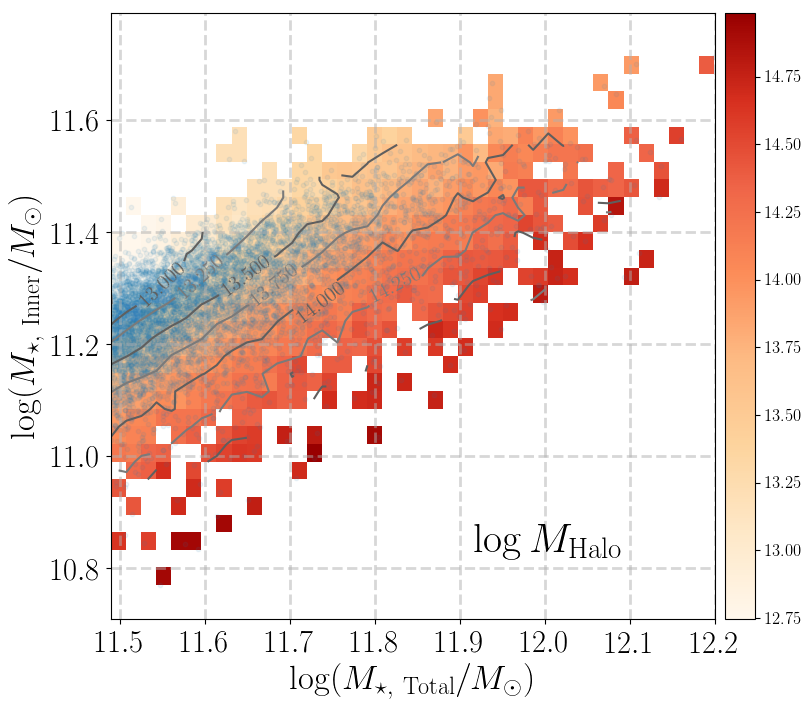

In [22]:
xx = np.array(obs_mass['logm_max'])
yy = np.array(obs_mass['logm_10'])
zz = logmh_vir_model

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, 
                           x_lim=[11.49, 12.2], 
                           y_lim=[10.71, 11.79],
                           n_contour=9, scatter=True)

#### Try to fit the stellar mass fundamental plane

In [54]:
vdisp_mask = ((obs_mass['vdisp_sdss'] >= 85.0) & 
              (obs_mass['vdisp_sdss'] <= 450.0) &
              (obs_mass['r50_max'] <= 50.0) & 
              (obs_mass['logm_max'] >= 11.4) & 
              (obs_mass['c82_max'] <= 20))

print(sum(vdisp_mask))

obs_vdisp = obs_mass[vdisp_mask]

obs_vdisp.write('s16a_massive_vdisp_with_asap_halo_mass.fits', format='fits',
                overwrite=True)

logmh_vir_vdisp = logmh_vir_model[vdisp_mask]

logms = np.array(obs_vdisp['logm_max'])
logvd = np.array(np.log10(obs_vdisp['vdisp_sdss']))
logre = np.array(np.log10(obs_vdisp['r50_max']))
logmu = np.array(obs_vdisp['logm_max'] - 2.0 * np.log10(obs_vdisp['r50_max']) - 0.8)
logmh = np.array(logmh_vir_vdisp)

6590


In [55]:
hsc_fp_data_1 = np.c_[logvd, logms, logre]
hsc_fp_data_2 = np.c_[logvd, logmu, logre]

In [56]:
X_1, Y_1 = np.meshgrid(np.arange(logvd.min() - 0.01, logvd.max() + 0.01, 0.01), 
                       np.arange(logms.min() - 0.01, logms.max() + 0.01, 0.01))

A_1 = np.c_[hsc_fp_data_1[:,0], hsc_fp_data_1[:,1], 
            np.ones(hsc_fp_data_1.shape[0])]
C_1, _, _, _ = scipy.linalg.lstsq(A_1, hsc_fp_data_1[:,2])  
Z_1 = C_1[0] * X_1 + C_1[1] * Y_1 + C_1[2]

print(C_1)

[-0.28624198  0.78642423 -7.42038006]


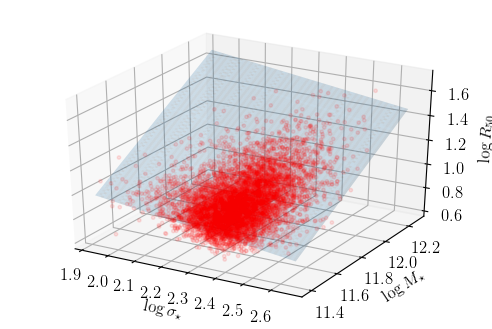

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_1, Y_1, Z_1, rstride=1, 
                cstride=1, alpha=0.2)
ax.scatter(hsc_fp_data_1[:,0], hsc_fp_data_1[:,1], hsc_fp_data_1[:,2], 
           c='r', s=6, alpha=0.1)
plt.xlabel(r'$\log \sigma_{\star}$')
plt.ylabel(r'$\log M_{\star}$')
ax.set_zlabel(r'$\log R_{50}$')
ax.axis('equal')
ax.axis('tight')
plt.show()

In [27]:
X_2, Y_2 = np.meshgrid(np.arange(logvd.min() - 0.01, logvd.max() + 0.01, 0.01), 
                       np.arange(logmu.min() - 0.01, logmu.max() + 0.01, 0.01))

A_2 = np.c_[hsc_fp_data_2[:,0], hsc_fp_data_2[:,1], 
            np.ones(hsc_fp_data_2.shape[0])]
C_2, _, _, _ = scipy.linalg.lstsq(A_2, hsc_fp_data_2[:,2])  
Z_2 = C_2[0] * X_2 + C_2[1] * Y_2 + C_2[2]

print(C_2)

[ 0.27570517 -0.5892867   5.52169495]


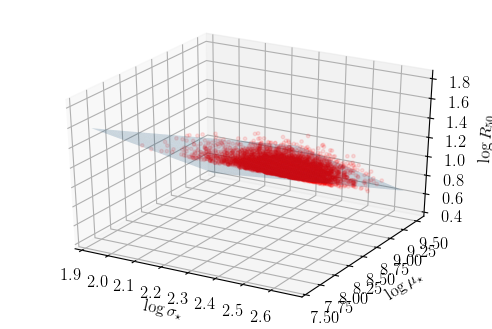

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_2, Y_2, Z_2, rstride=1, 
                cstride=1, alpha=0.2)
ax.scatter(hsc_fp_data_2[:,0], hsc_fp_data_2[:,1], hsc_fp_data_2[:,2], 
           c='r', s=6, alpha=0.1)
plt.xlabel(r'$\log \sigma_{\star}$')
plt.ylabel(r'$\log \mu_{\star}$')
ax.set_zlabel(r'$\log R_{50}$')
ax.axis('equal')
ax.axis('tight')
plt.show()

In [29]:
print(np.std(logre - (C_1[0] * logvd + C_1[1] * logms + C_1[2])))
print(np.std(logre - (C_2[0] * logvd + C_2[1] * logmu + C_2[2])))
print(np.std(logre - (-2.0 * logvd + 1.0 * logms + 8.0)))
print(np.std(logre - (-0.93 * logvd + 0.92 * logms - 7.58)))

0.10429523767101224
0.0582308319848196
0.17789539819237646
0.11719829934211791


In [120]:
def fp_logms(logvd, logms, params):
    logre = params[0] * logvd + params[1] * logms + params[2]
    return logre

def fp_logmu(logvd, logmu, params):
    logre = params[0] * logvd + params[1] * logmu + params[2]
    return logre

def fp_logms_chi2(params, logvd, logms, logre):
    const = np.sqrt(1.0 + params[0] ** 2.0 + params[1] ** 2.0)
    logre_fp = fp_logms(logvd, logms, params)
    return abs((logre - logre_fp) / const) ** 2

def fp_logmu_chi2(params, logvd, logmu, logre):
    const = np.sqrt(1.0 + params[0] ** 2.0 + params[1] ** 2.0)
    logre_fp = fp_logmu(logvd, logmu, params)
    return abs((logre - logre_fp) / const) ** 2

def fp_lnlike_logms(params, logvd, logms, logre):
    chi2 = fp_logms_chi2(params, logvd, logms, logre)
    return -0.5 * chi2.sum()

def fp_lnlike_logmu(params, logvd, logmu, logre):
    chi2 = fp_logmu_chi2(params, logvd, logmu, logre)
    return -0.5 * chi2.sum()

def fp_lnprior_logms(params):
    a, b, c = params
    if -5.0 < a < 0.0 and 0.0 < b < 3.0 and -10.0 < c < 10.0:
        return 0.0
    return -np.inf

def fp_lnprior_logmu(params):
    a, b, c = params
    if 0.0 < a < 5.0 and -4.0 < b < -0.2 and -12.0 < c < 12.0:
        return 0.0
    return -np.inf

def fp_lnprob_logms(params, logvd, logms, logre):
    lp = fp_lnprior_logms(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + fp_lnlike_logms(params, logvd, logms, logre)

def fp_lnprob_logmu(params, logvd, logmu, logre):
    lp = fp_lnprior_logmu(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + fp_lnlike_logmu(params, logvd, logmu, logre)

In [121]:
pos0 = np.array([-1.4, 1.0, -7.5]) + 1e-1 * np.random.randn(128, 3)
n_walker, n_dim = pos0.shape

sampler = emcee.EnsembleSampler(n_walker, n_dim, fp_lnprob_logms, 
                                args=(logvd, logms, logre))
pos, log_prob, rstate = sampler.run_mcmc(pos0, 1000, progress=True)

100%|██████████| 1000/1000 [00:10<00:00, 95.25it/s]


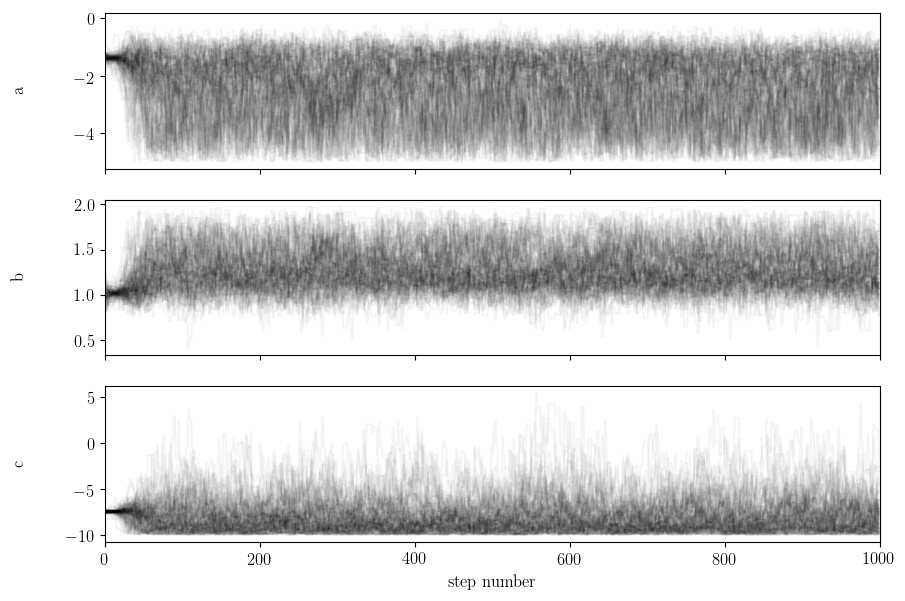

In [122]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.04)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

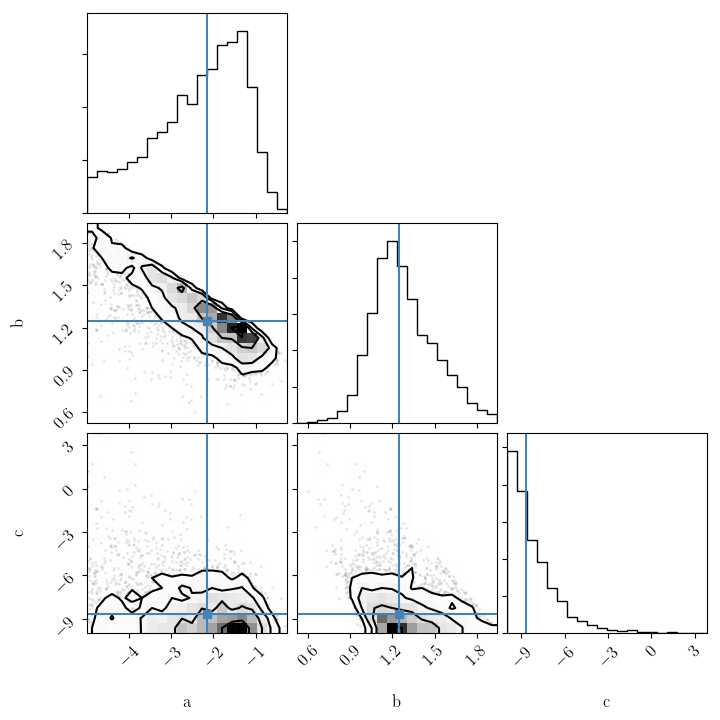

In [123]:
flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [124]:
np.median(flat_samples, axis=0)

array([-2.16093271,  1.24466828, -8.6928464 ])

In [125]:
pos0 = np.array([1.4, -1.5, 5.5]) + 2e-1 * np.random.randn(128, 3)
n_walker, n_dim = pos0.shape

sampler = emcee.EnsembleSampler(n_walker, n_dim, fp_lnprob_logmu, 
                                args=(logvd, logmu, logre))

pos, log_prob, rstate = sampler.run_mcmc(pos0, 1200, progress=True)

100%|██████████| 1200/1200 [00:13<00:00, 90.10it/s]


In [126]:
pos[np.argmin(log_prob)]

array([ 0.88997196, -0.86537724,  6.46211285])

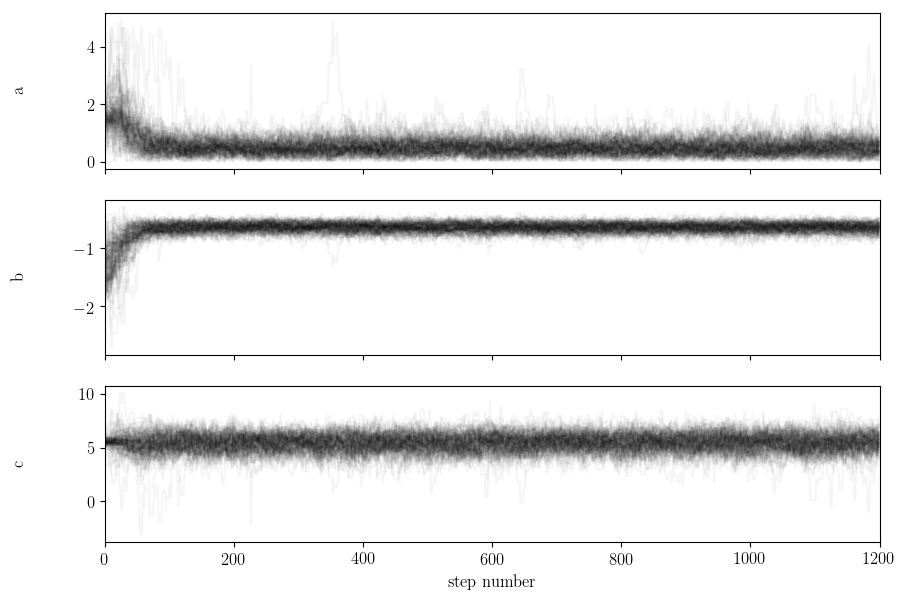

In [127]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.04)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

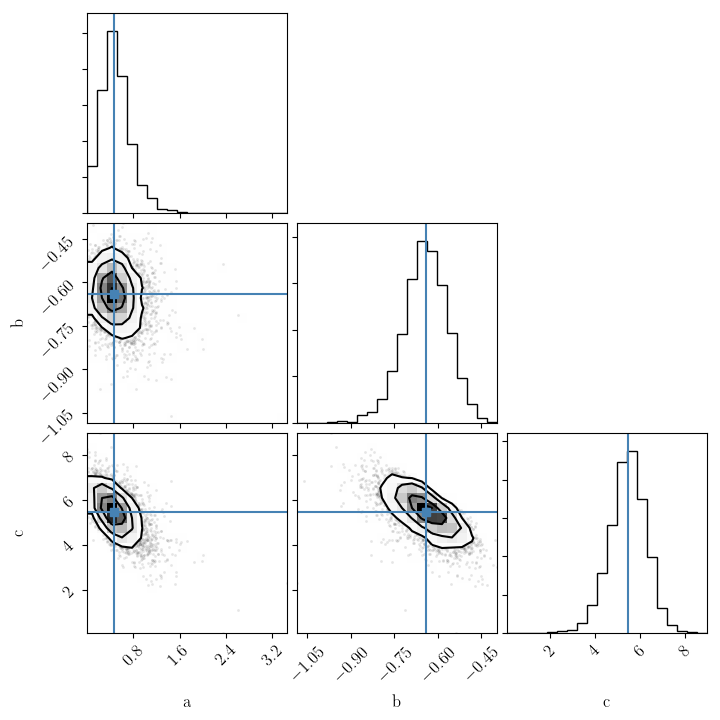

In [128]:
flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [130]:
np.median(flat_samples, axis=0)

array([ 0.47066381, -0.64090041,  5.48280252])

sig_int:     0.0000     -0.7201
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.7201
################# Values and formal errors ################
 intercept:  0.9965 +/- 0.0013
    slopeX:  0.33 +/- 0.015
    slopeY:  -0.6276 +/- 0.006
   scatter:  0 +/- 0
Observed rms scatter: 0.0548 
z = a + b*(x - pivotx) + c*(y - pivoty)
with pivotx = 2.372 & pivoty = 8.784
##########################################################
seconds 10.08


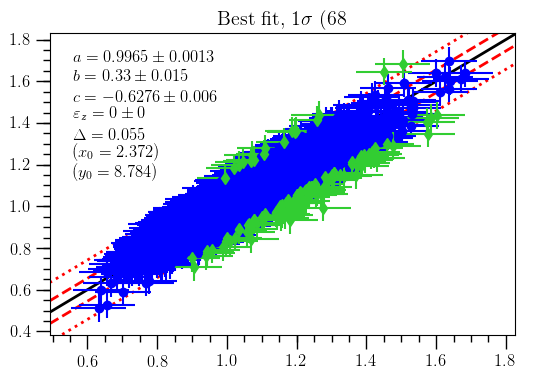

In [118]:
sig_vd = logvd * 0.0 + 0.06
sig_mu = logmu * 0.0 + 0.10
sig_re = logre * 0.0 + 0.08

p = lts_planefit(logvd, logmu, logre, sig_vd, sig_mu, sig_re, 
                 pivotx=np.median(logvd), pivoty=np.median(logmu))

<IPython.core.display.Javascript object>


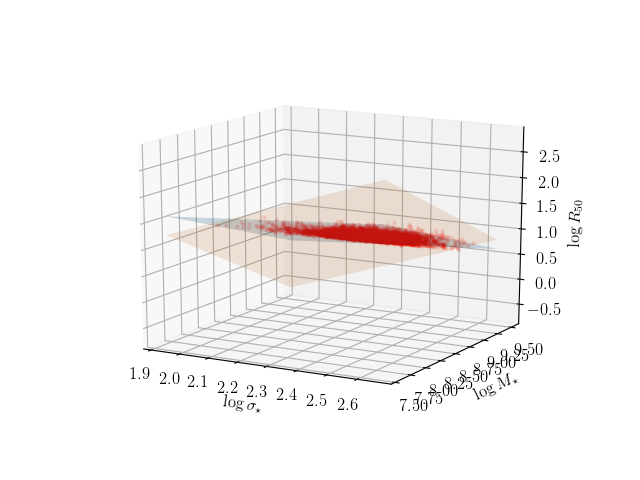

In [24]:
X_2, Y_2 = np.meshgrid(np.arange(logvd.min() - 0.01, logvd.max() + 0.01, 0.01), 
                       np.arange(logmu.min() - 0.01, logmu.max() + 0.01, 0.01))

Z_2 = 0.4133 * (X_2 - 2.372) - 0.6764 * (Y_2 - 8.784) + 0.9972
Z_3 = 2.0 * X_2 - 1.0 * Y_2 + 5.0


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_2, Y_2, Z_2, rstride=1, 
                cstride=1, alpha=0.2)

ax.plot_surface(X_2, Y_2, Z_3, rstride=1, 
                cstride=1, alpha=0.15)

ax.scatter(logvd, logmu, logre, 
           c='r', s=5, alpha=0.1)

plt.xlabel(r'$\log \sigma_{\star}$')
plt.ylabel(r'$\log M_{\star}$')
ax.set_zlabel(r'$\log R_{50}$')
ax.axis('equal')
ax.axis('tight')
plt.show()

In [69]:
print(p.abc)

[ 0.99719865  0.4133083  -0.67644093]


#### logMs_Max v.s. log(vdisp) (Halo mass; M10_kpc, R50)

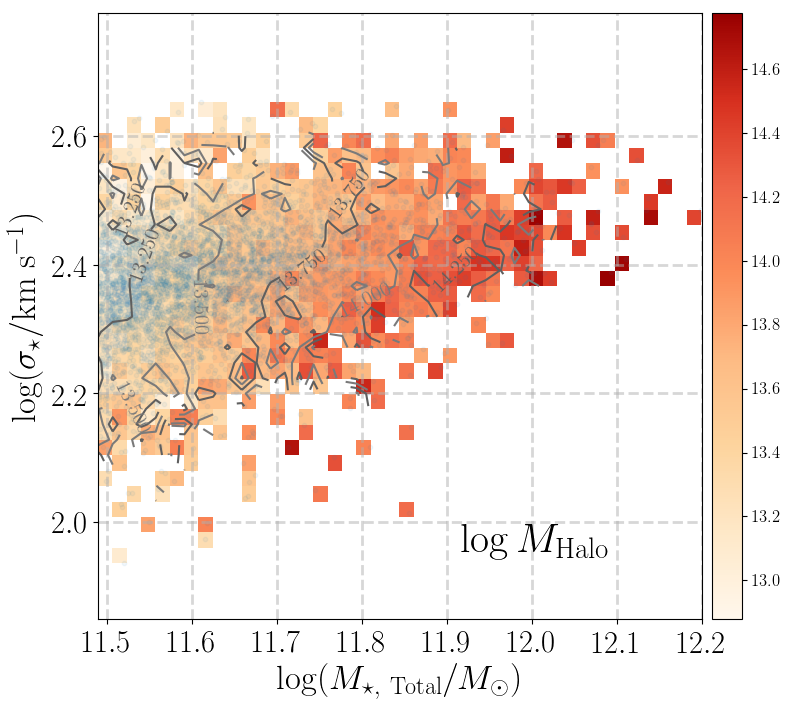

In [33]:
xx = logms
yy = logvd
zz = logmh

vdisp_label = r'$\log (\sigma_{\star}/\mathrm{km}\ \mathrm{s}^{-1})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, x_bins=42,
                           x_lim=[11.49, 12.2], y_lim=[1.85, 2.79],
                           n_contour=7, scatter=True, s_alpha=0.06,
                           ylabel=vdisp_label, gaussian=0.03)

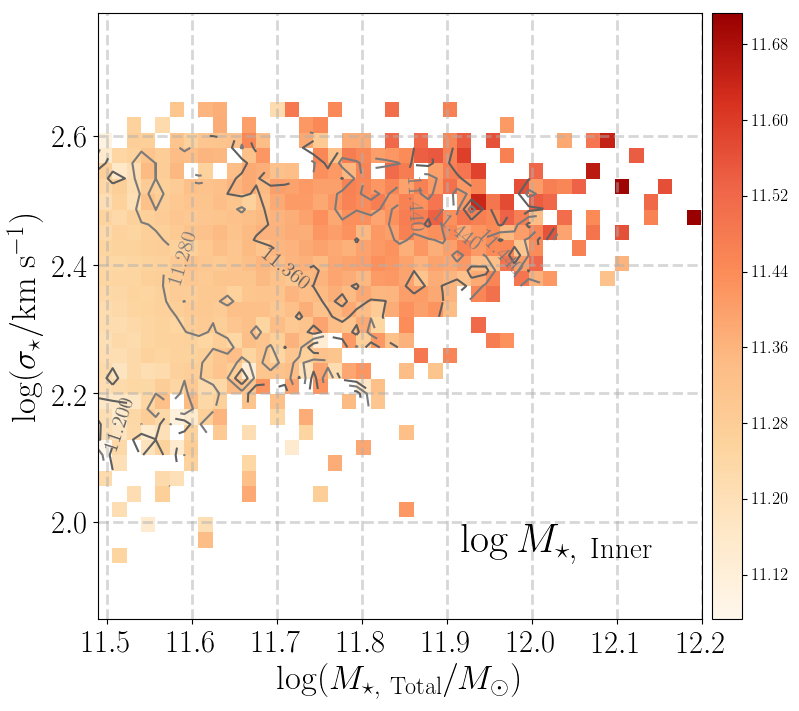

In [34]:
xx = logms
yy = logvd
zz = np.array(obs_vdisp['logm_10'])

vdisp_label = r'$\log (\sigma_{\star}/\mathrm{km}\ \mathrm{s}^{-1})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, x_bins=42,
                           x_lim=[11.49, 12.2], y_lim=[1.85, 2.79],
                           n_contour=7, scatter=False, s_alpha=0.06,
                           title=r'$\log M_{\star,\ \mathrm{Inner}}$',
                           ylabel=vdisp_label, gaussian=0.05)

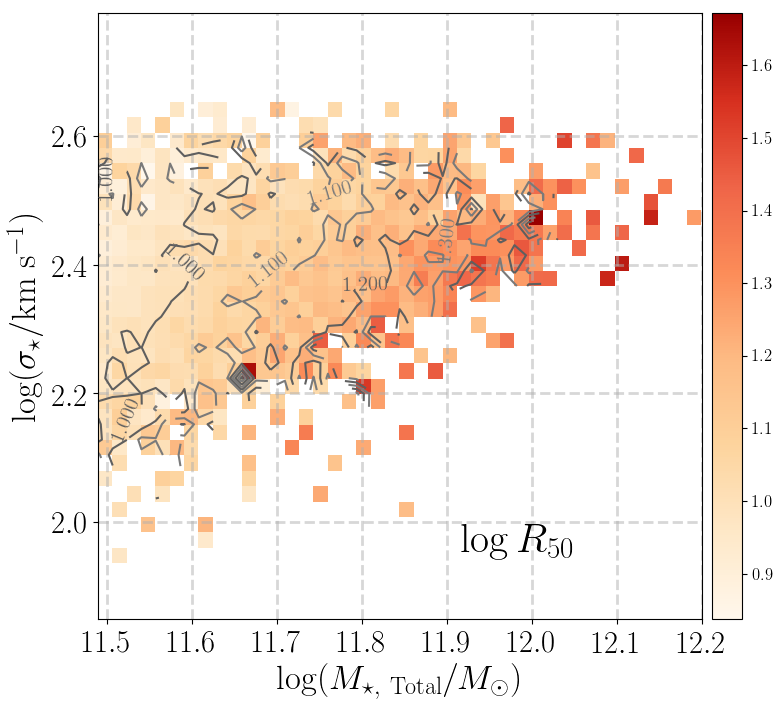

In [35]:
xx = np.array(obs_vdisp['logm_max'])
yy = np.array(np.log10(obs_vdisp['vdisp_sdss']))
zz = np.array(np.log10(obs_vdisp['r50_max']))

vdisp_label = r'$\log (\sigma_{\star}/\mathrm{km}\ \mathrm{s}^{-1})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, x_bins=42,
                           x_lim=[11.49, 12.2], y_lim=[1.85, 2.79],
                           n_contour=9, scatter=False, 
                           title=r'$\log R_{50}$',
                           ylabel=vdisp_label, gaussian=0.03)

#### logMs_Max v.s. log(R50) (Halo mass; M10_kpc, vdisp)

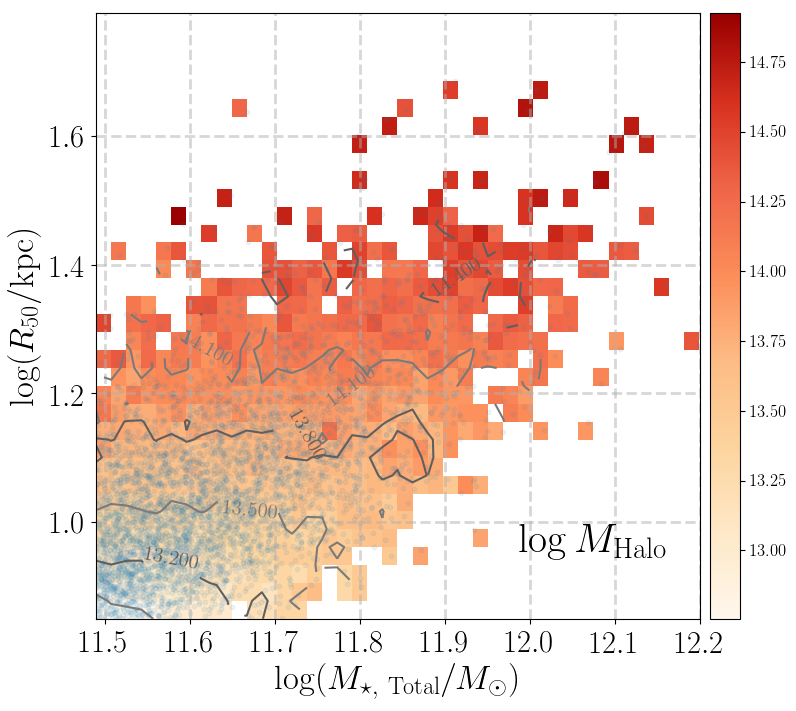

In [36]:
xx = logms
yy = logre
zz = logmh

r50_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[11.49, 12.2], y_lim=[0.85, 1.79],
                           n_contour=7, scatter=True, x_title=0.7,
                           ylabel=r50_label, gaussian=0.05)

<IPython.core.display.Javascript object>


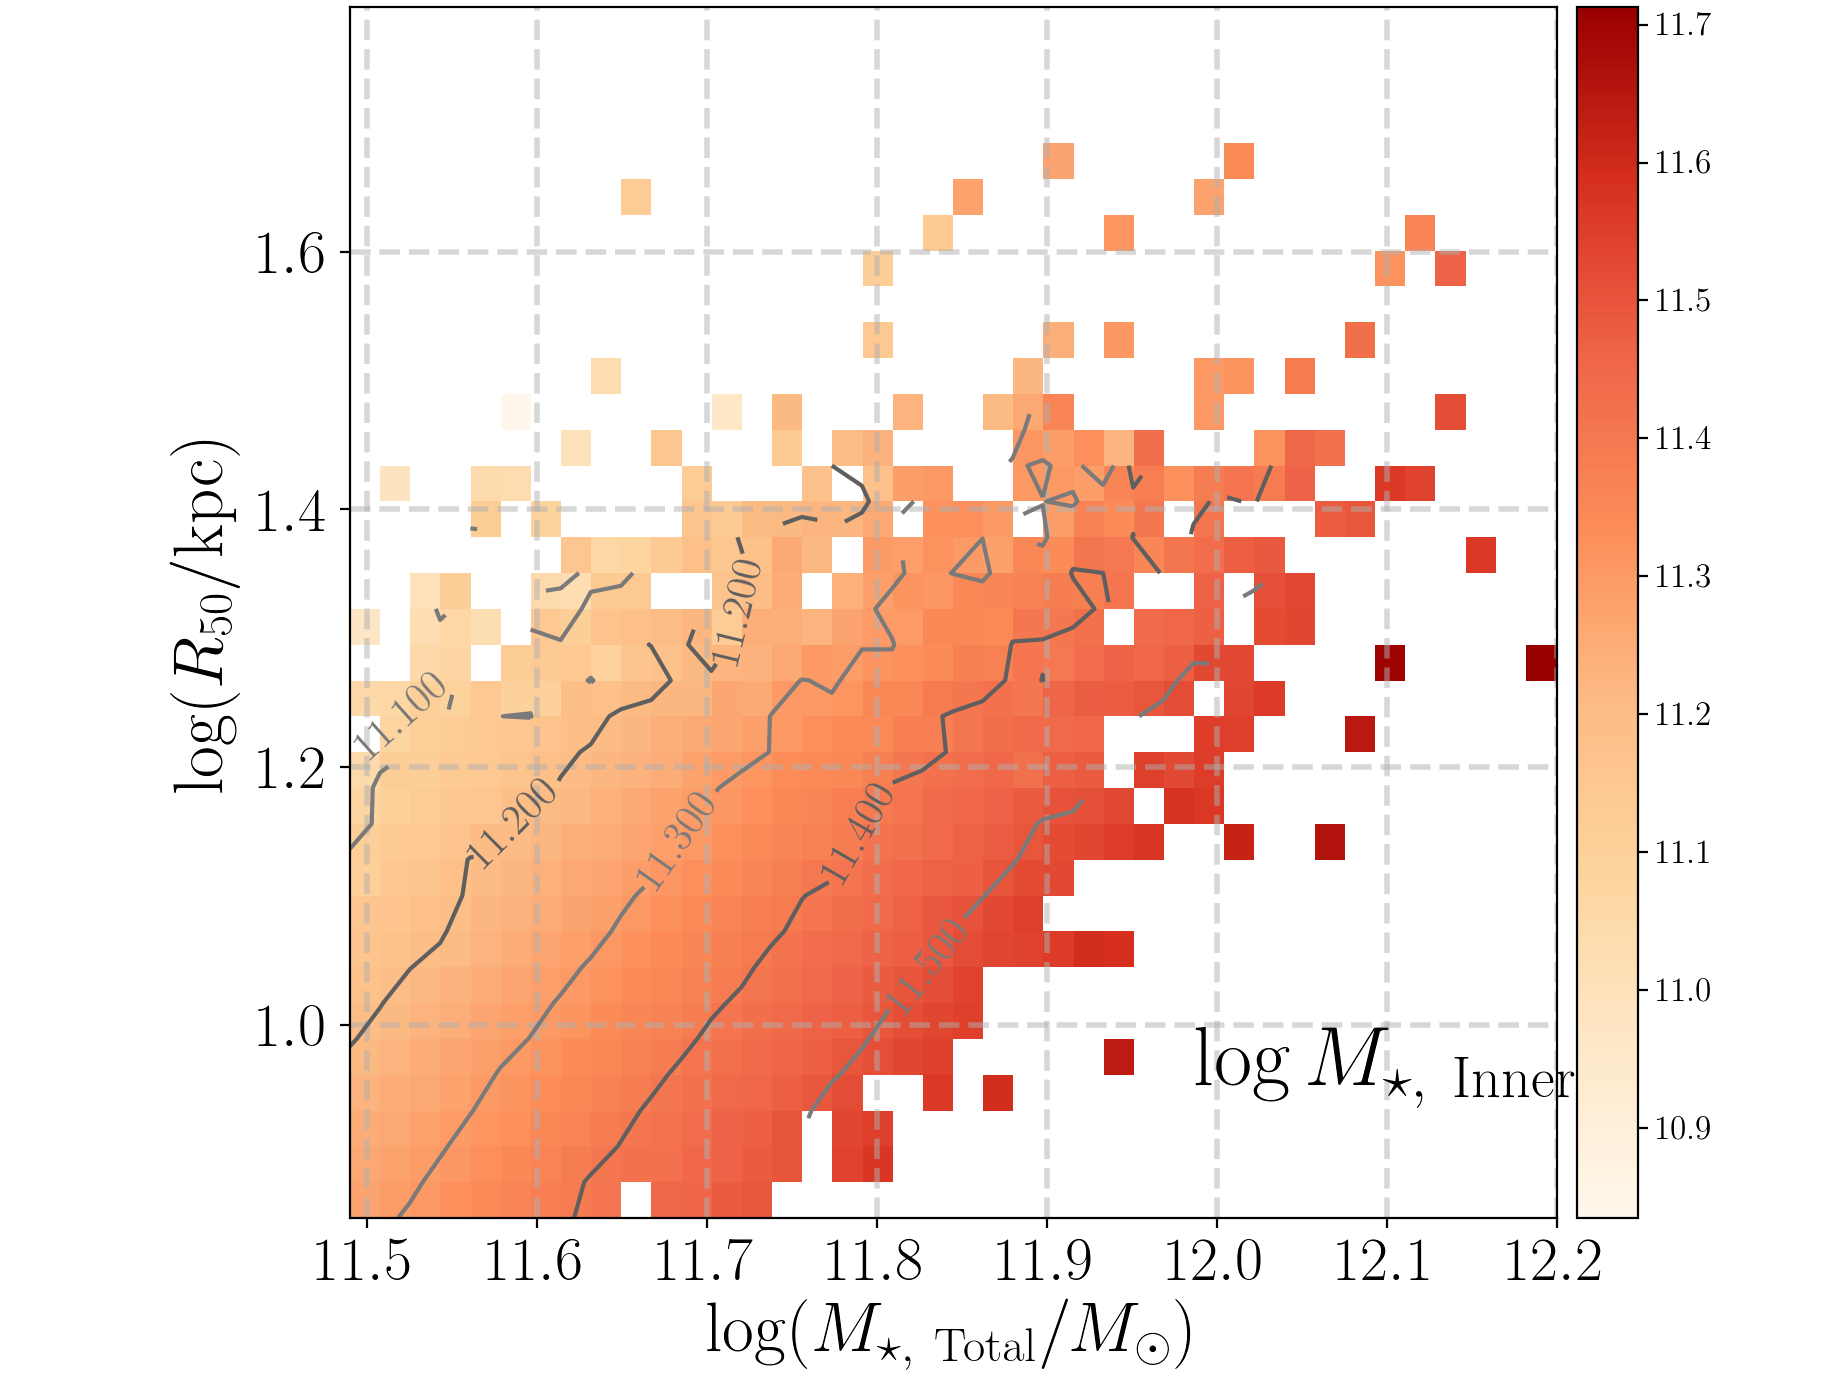

In [124]:
xx = logms
yy = logre
zz = np.array(obs_vdisp['logm_10'])

r50_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[11.49, 12.2], y_lim=[0.85, 1.79],
                           n_contour=9, scatter=False, x_title=0.7,
                           title=r'$\log M_{\star,\ \mathrm{Inner}}$',
                           ylabel=r50_label, gaussian=0.1)

<IPython.core.display.Javascript object>


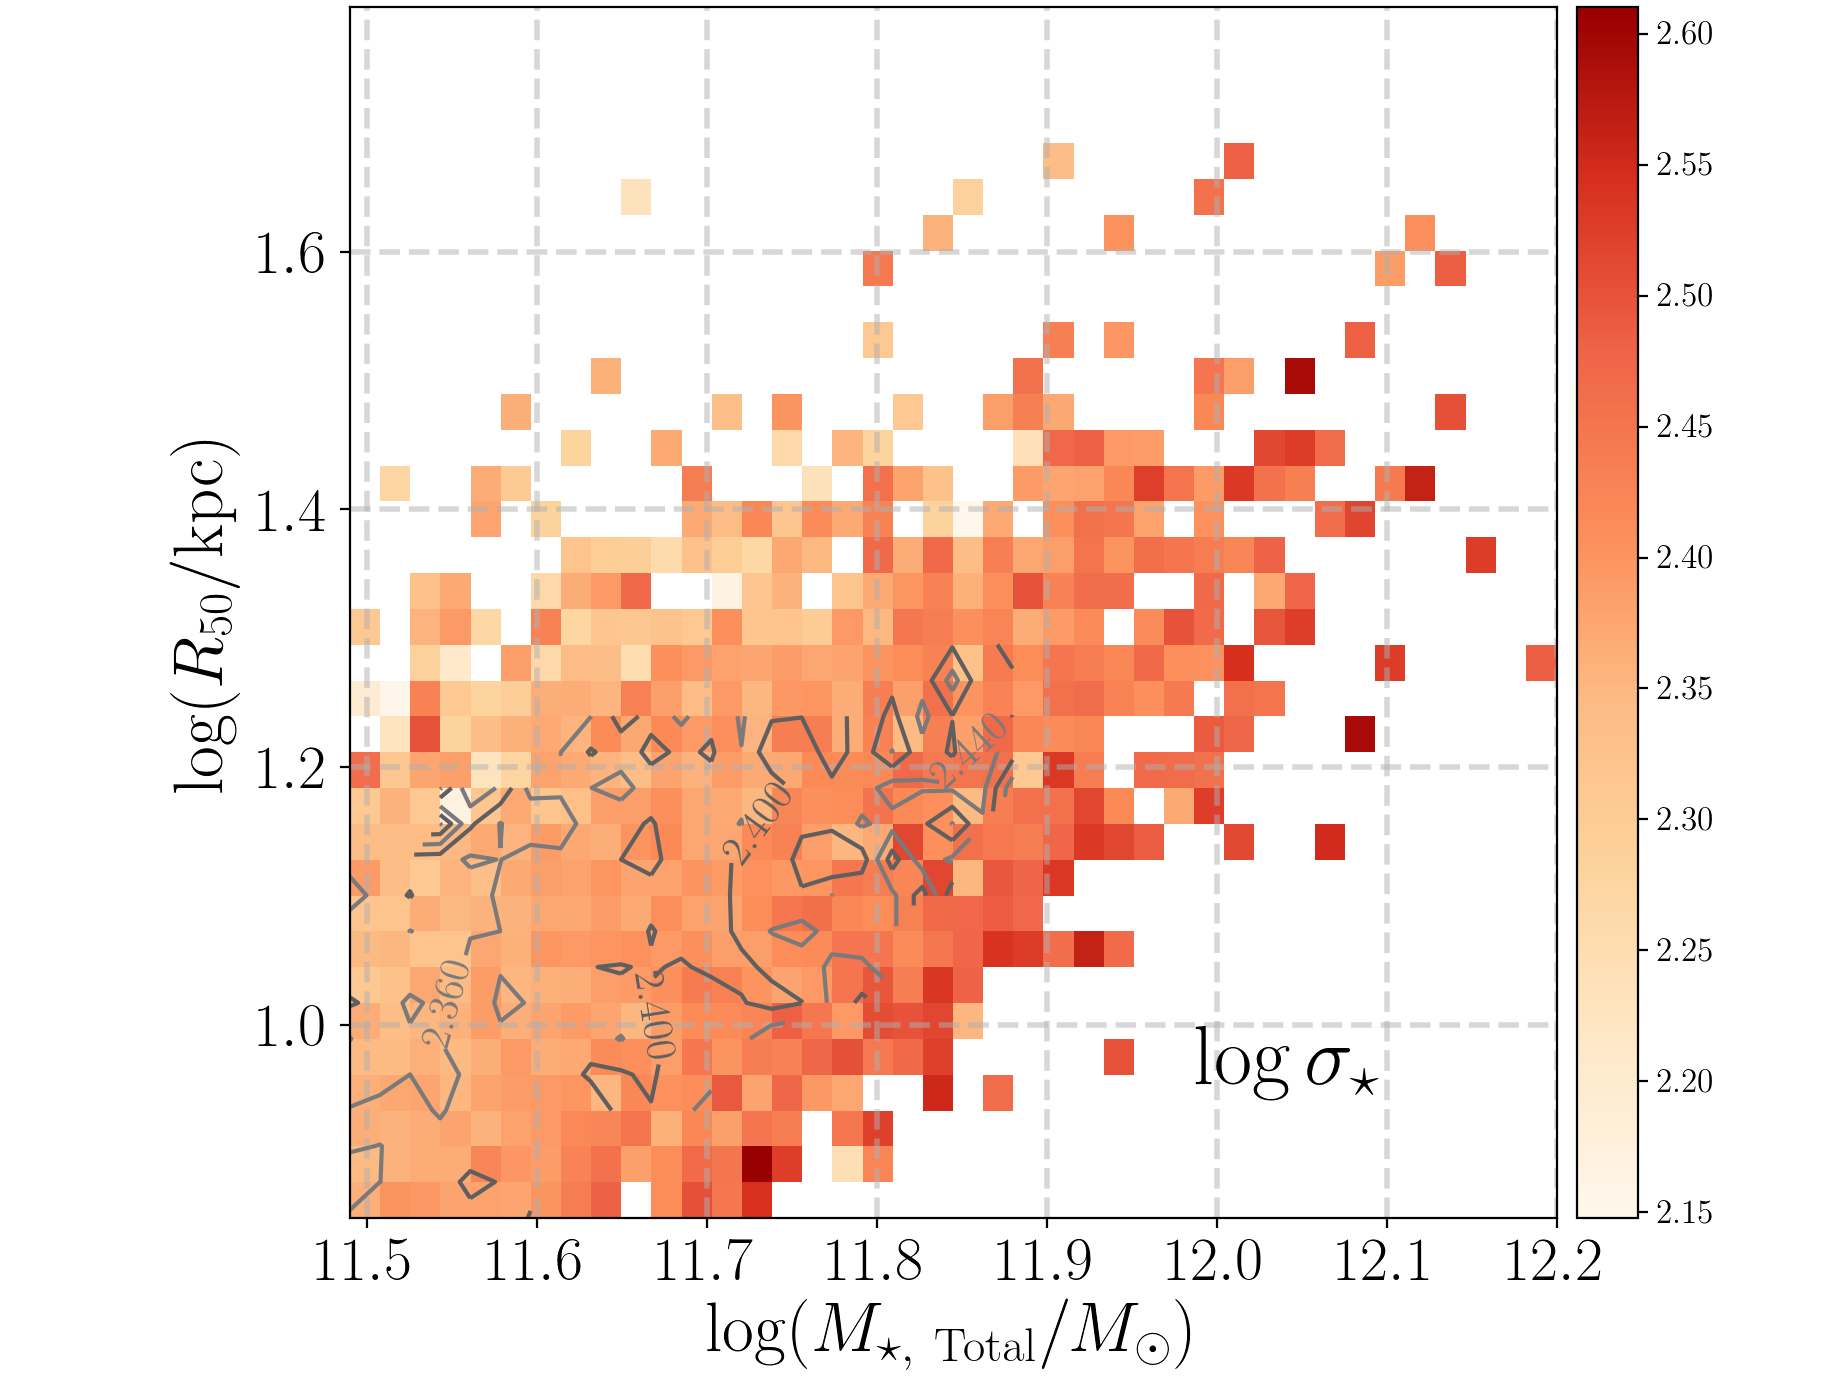

In [125]:
xx = logms
yy = logre
zz = logvd

r50_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[11.49, 12.2], y_lim=[0.85, 1.79],
                           n_contour=7, scatter=False, x_title=0.7,
                           title=r'$\log \sigma_{\star}$',
                           ylabel=r50_label, gaussian=0.4)

#### log(vdisp) v.s. log(R50) (Halo mass; M10_kpc, M100_kpc)

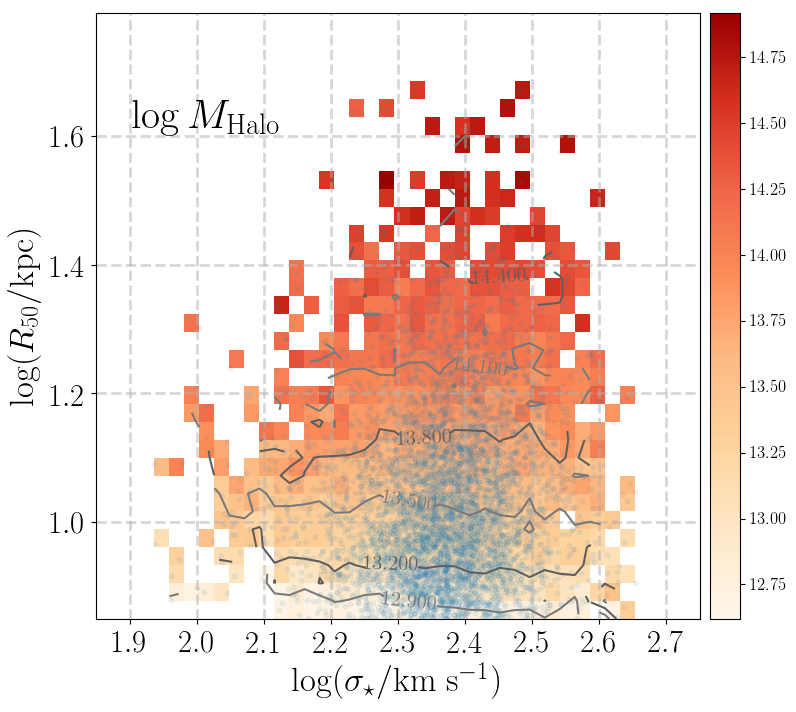

In [37]:
xx = logvd
yy = logre
zz = logmh

r50_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[1.85, 2.75], y_lim=[0.85, 1.79],
                           n_contour=7, scatter=True, x_bins=32,
                           xlabel=vdisp_label, ylabel=r50_label, 
                           gaussian=0.1, x_title=0.06, y_title=0.8)

<IPython.core.display.Javascript object>


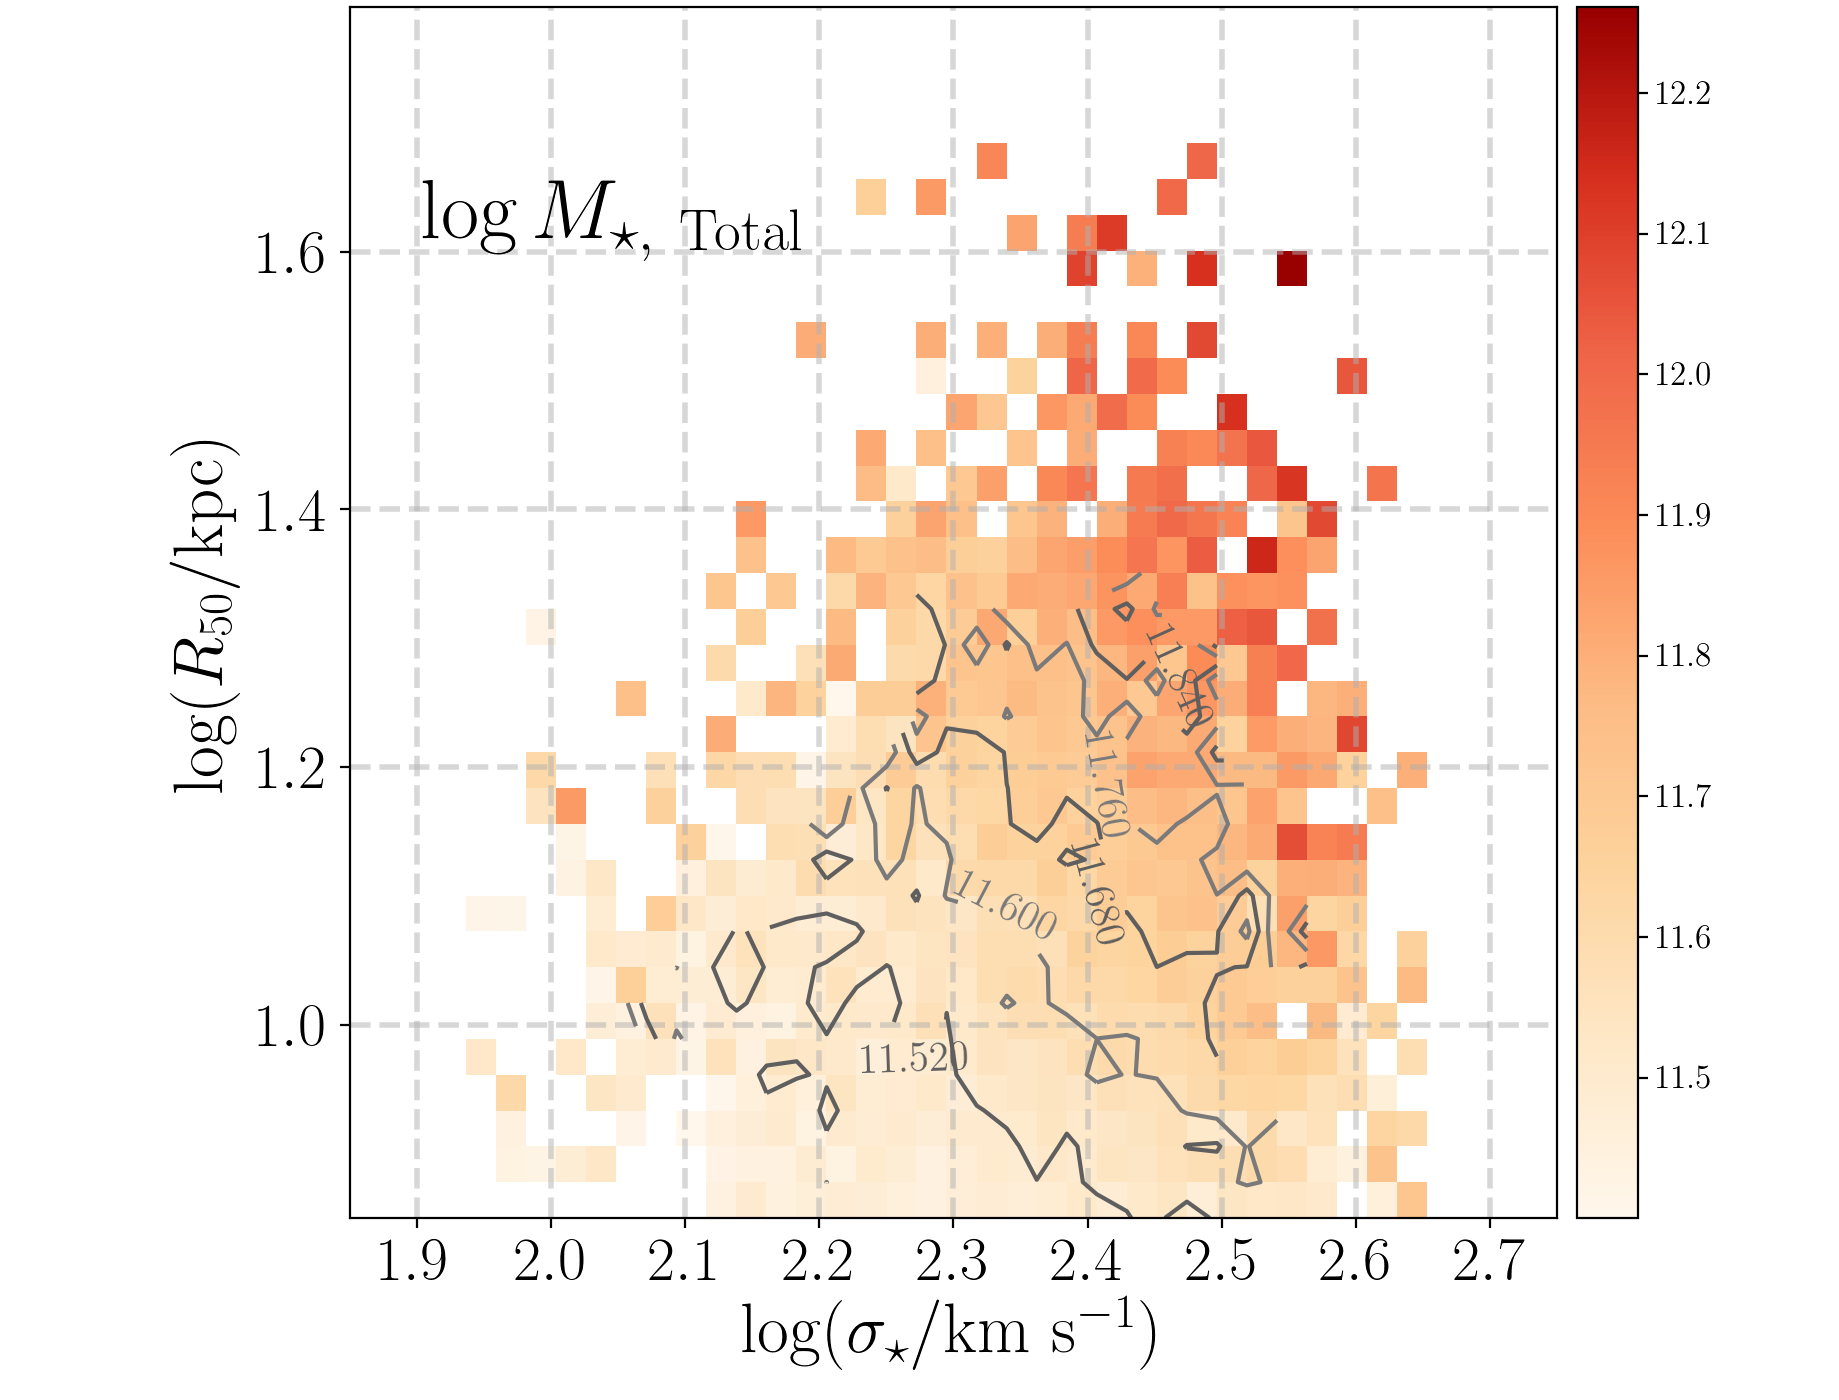

In [127]:
xx = logvd
yy = logre
zz = logms

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[1.85, 2.75], y_lim=[0.85, 1.79],
                           n_contour=7, scatter=False, x_bins=32,
                           xlabel=vdisp_label, ylabel=r50_label, 
                           title=r'$\log M_{\star,\ \mathrm{Total}}$',
                           gaussian=0.2, x_title=0.06, y_title=0.8)

<IPython.core.display.Javascript object>


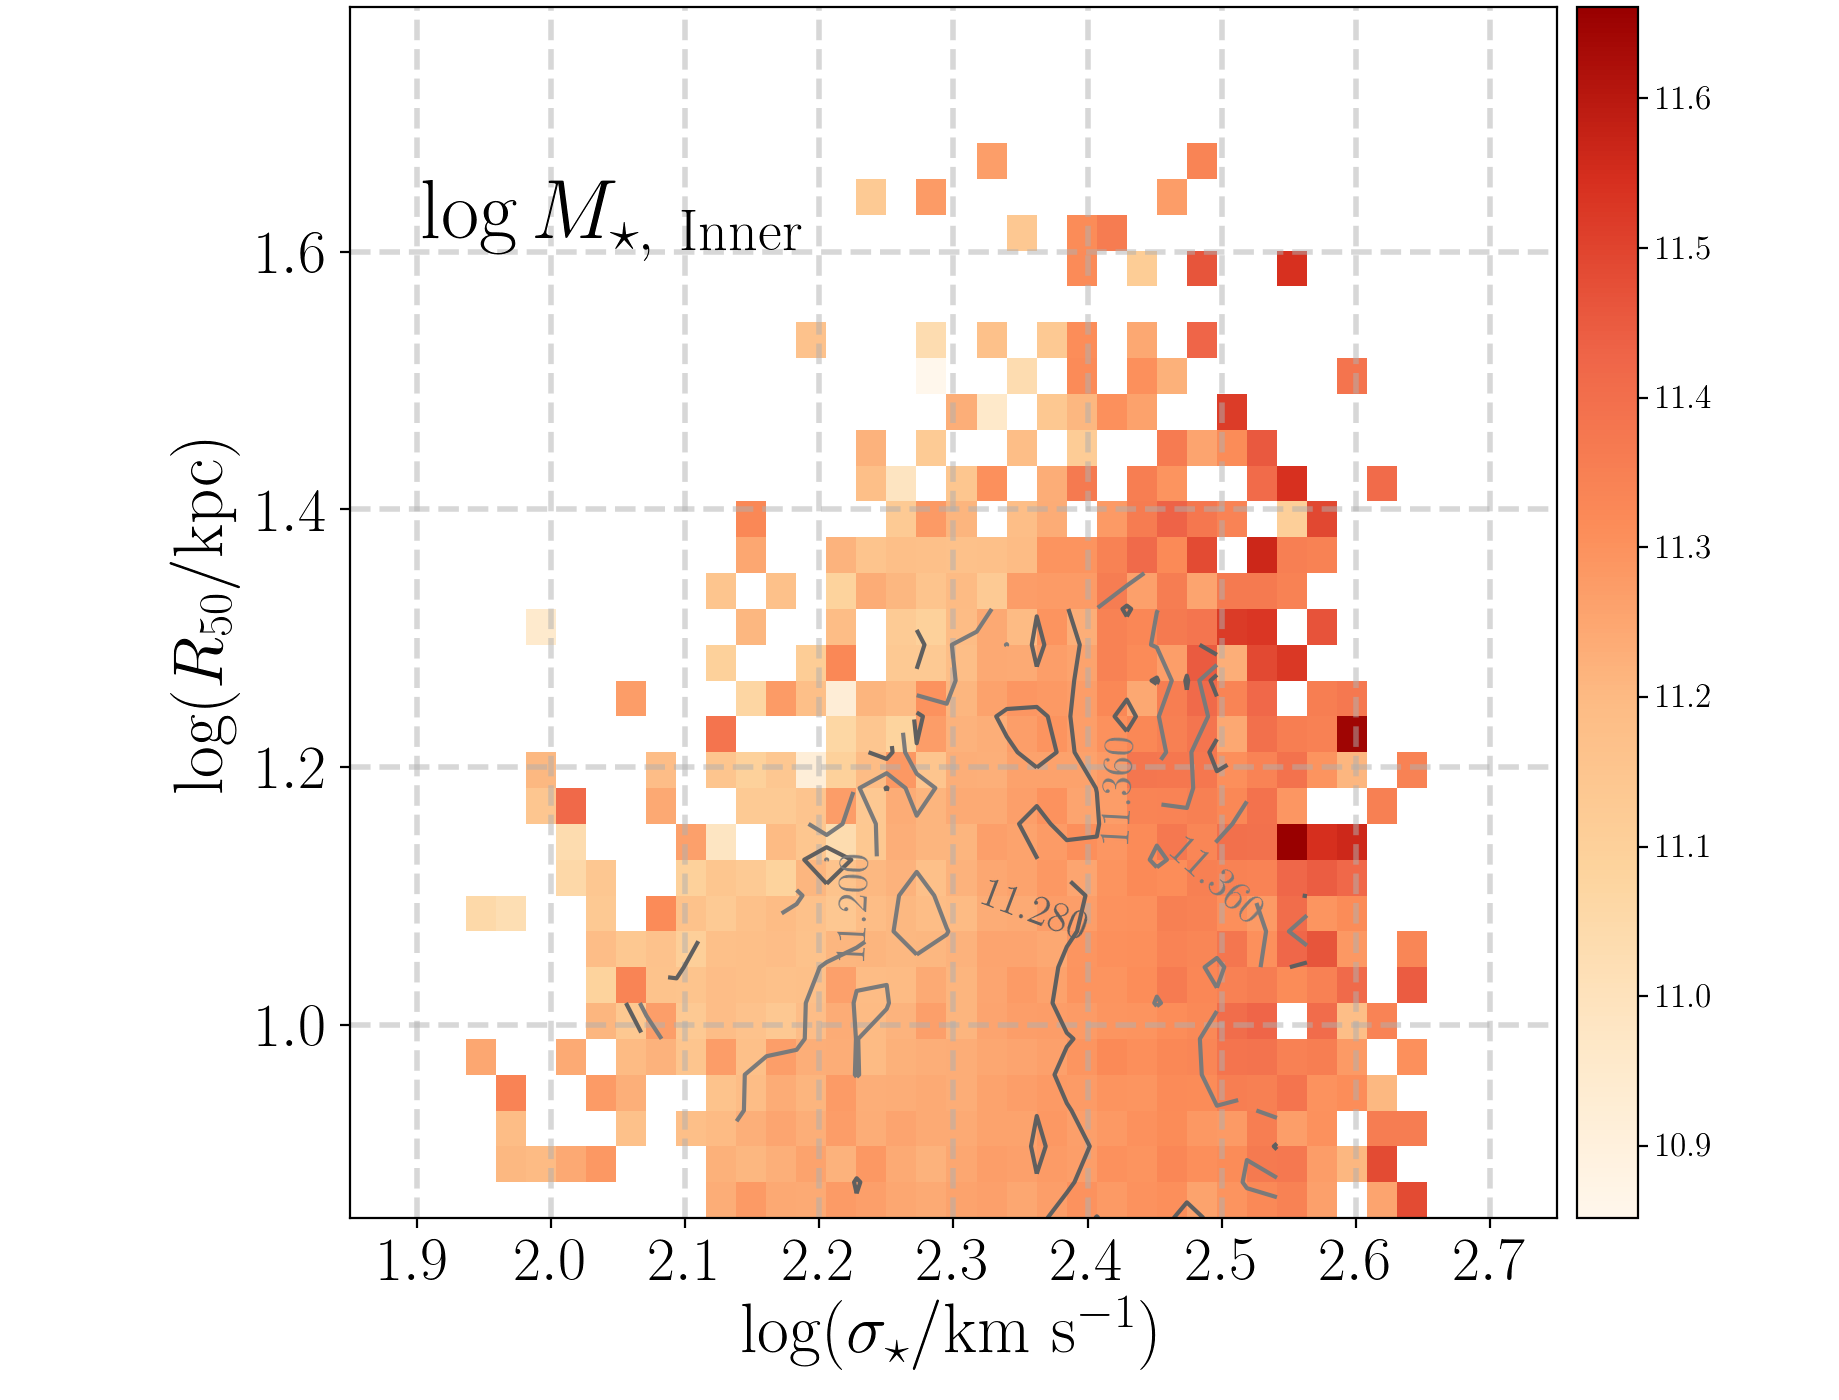

In [128]:
xx = logvd
yy = logre
zz = np.array(obs_vdisp['logm_10'])

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, 
                           x_lim=[1.85, 2.75], y_lim=[0.85, 1.79],
                           n_contour=7, scatter=False, x_bins=32,
                           xlabel=vdisp_label, ylabel=r50_label, 
                           title=r'$\log M_{\star,\ \mathrm{Inner}}$',
                           gaussian=0.3, x_title=0.06, y_title=0.8)

### Stellar mass fundamental plane

#### From Bexanson+2013

In [104]:
mm = logmh.ravel() >= 13.0

np.std((yy[mm] - xx[mm]))

0.138862380955757

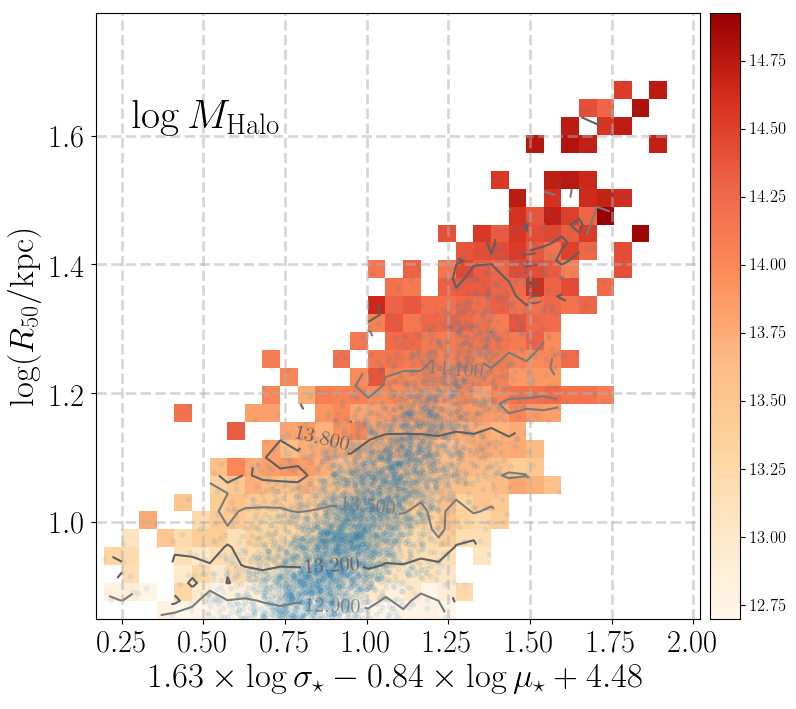

In [105]:
xx = 1.63 * logvd.ravel() - 0.84 * logmu.ravel() + 4.48
yy = logre.ravel()
zz = logmh.ravel()

x_label = r'$1.63 \times \log\sigma_{\star} - 0.84 \times \log \mu_{\star} + 4.48$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.1], 
                           y_lim=[0.85, 1.79],
                           n_contour=7, scatter=True, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.1, x_title=0.06, y_title=0.8)

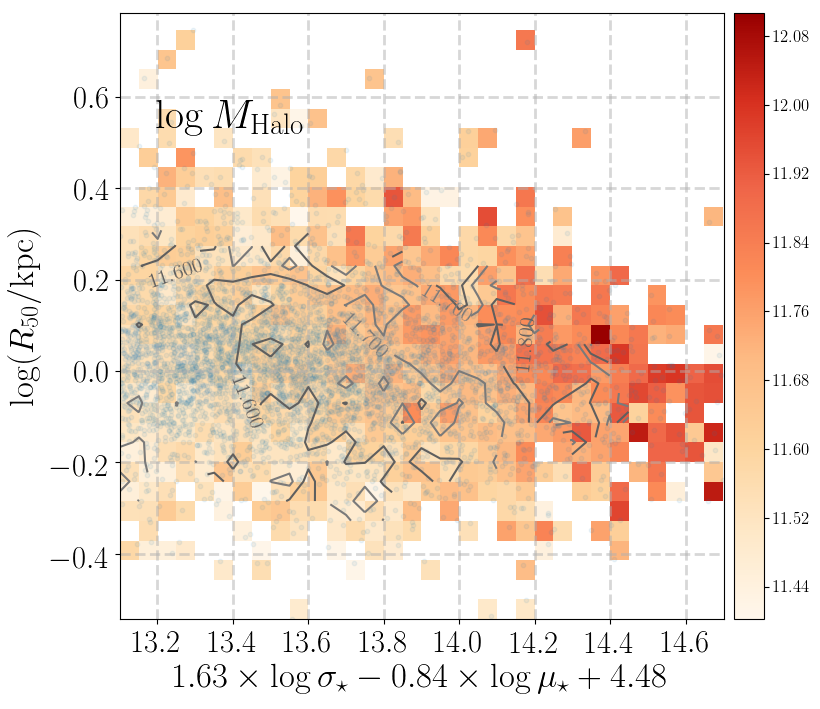

In [109]:
xx = logmh.ravel()
const = np.sqrt(1.0)
yy = (logre.ravel() - (1.63 * logvd.ravel() - 0.84 * logmu.ravel() + 4.48)) / const
zz = np.array(obs_vdisp['logm_max'])

x_label = r'$1.63 \times \log\sigma_{\star} - 0.84 \times \log \mu_{\star} + 4.48$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[13.1, 14.7],
                           n_contour=7, scatter=True, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.15, x_title=0.06, y_title=0.8)

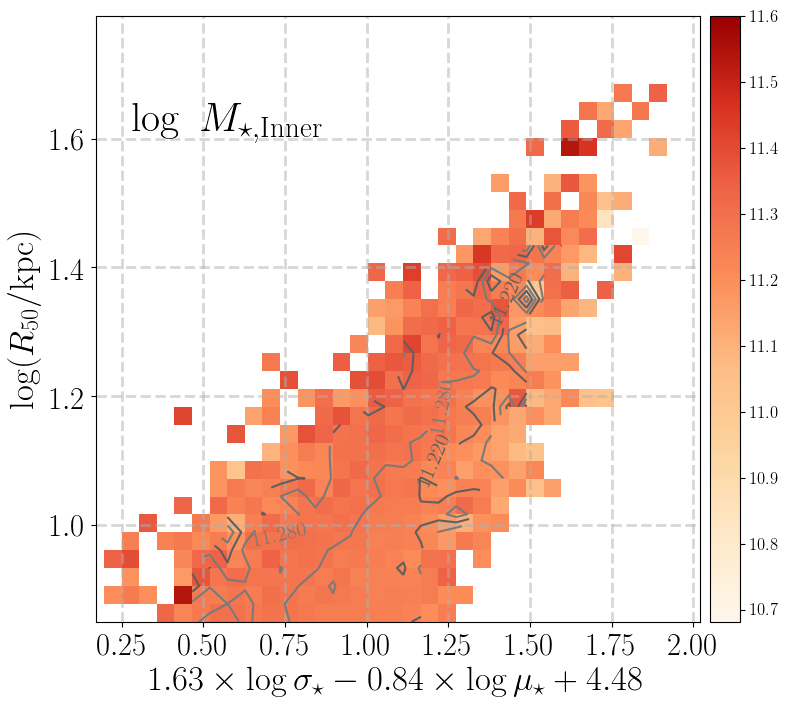

In [138]:
xx = 1.63 * logvd - 0.84 * logmu + 4.48
yy = logre
zz = np.array(obs_vdisp['logm_10'])

x_label = r'$1.63 \times \log\sigma_{\star} - 0.84 \times \log \mu_{\star} + 4.48$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.1], 
                           y_lim=[0.85, 1.79], z_max=11.6,
                           n_contour=7, scatter=False, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           title=r'$\log\ M_{\star, \mathrm{Inner}}$',
                           gaussian=0.3, x_title=0.06, y_title=0.8)

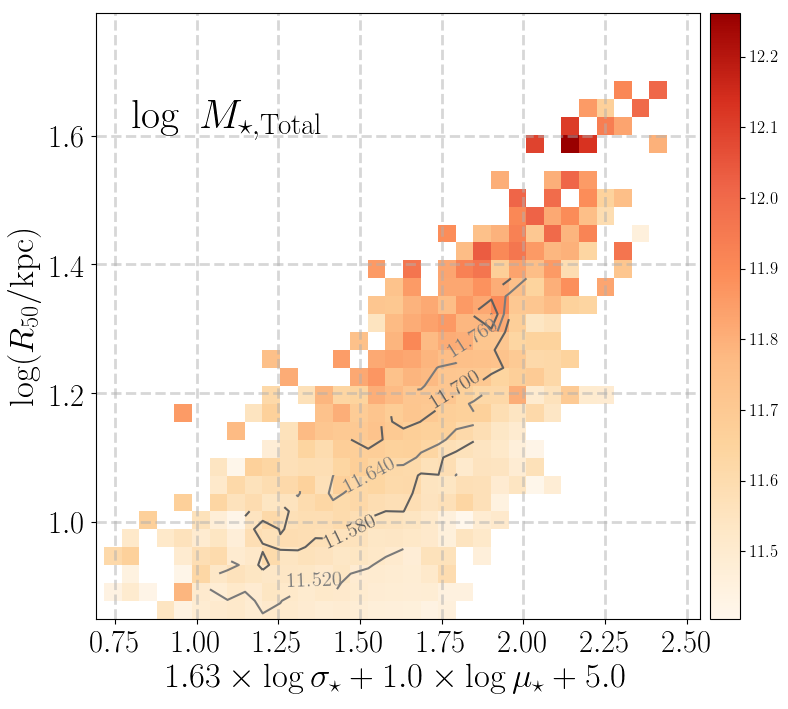

In [53]:
xx = 1.63 * logvd - 0.84 * logmu + 5.0
yy = logre
zz = np.array(obs_vdisp['logm_max'])

x_label = r'$1.63 \times \log\sigma_{\star} + 1.0 \times \log \mu_{\star} + 5.0$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'


# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.mean, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.1], 
                           y_lim=[0.85, 1.79],
                           n_contour=7, scatter=False, x_bins=32,
                           xlabel=x_label, ylabe=y_label, 
                           title=r'$\log\ M_{\star, \mathrm{Total}}$',
                           gaussian=0.4, x_title=0.06, y_title=0.8)

#### Best-fit stellar mass fundmental plane

In [88]:
np.std(yy - xx)


0.13149193462019595

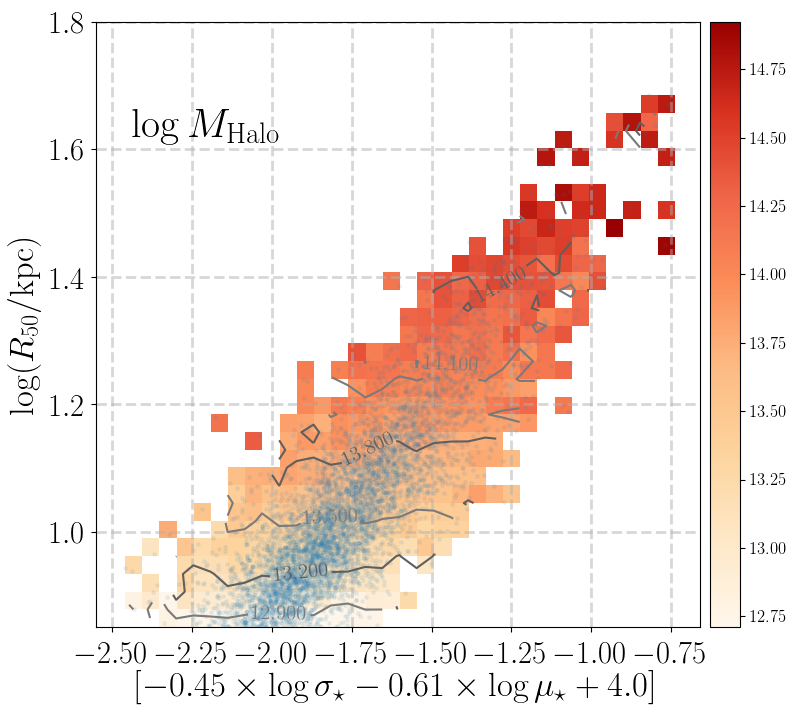

In [87]:
xx = 1.251 * logvd - 1.0 * logmu + 3.998
yy = logre
zz = logmh

x_label = r'$[-0.45 \times \log\sigma_{\star} - 0.61 \times \log \mu_{\star} + 4.0]$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.08], 
                           y_lim=[0.85, 1.8],
                           n_contour=7, scatter=True, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.05, x_title=0.06, y_title=0.8, 
                           s_alpha=0.08, s_size=6)

In [114]:
p.abc
0.47066381, -0.64090041,  5.48280252

array([ 0.99659733,  0.36391887, -0.64978696])

In [132]:
np.std(yy - xx)

0.061771489353941014

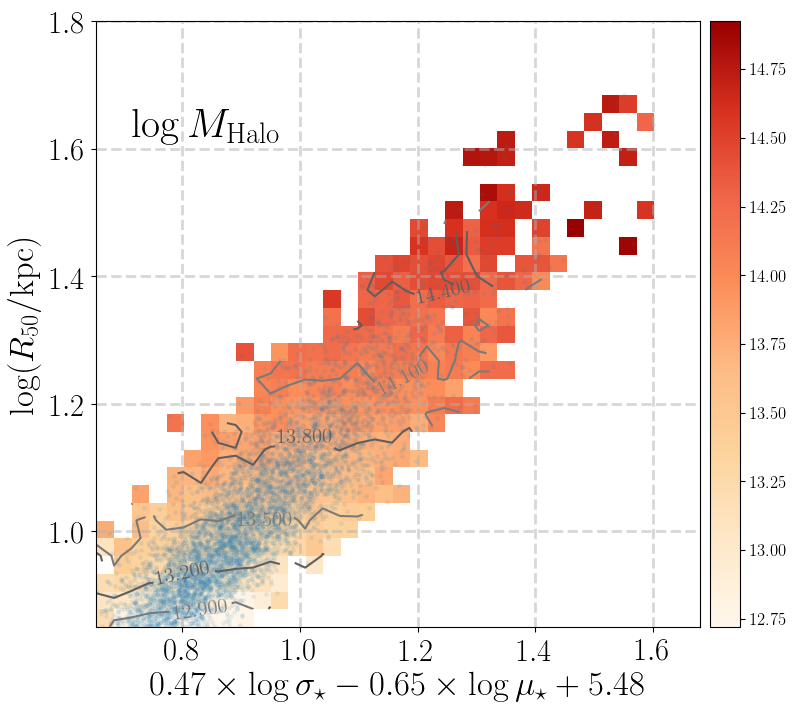

In [133]:
xx = 0.471 * logvd - 0.65 * logmu + 5.482
yy = logre
zz = logmh

x_label = r'$0.47 \times \log\sigma_{\star} - 0.65 \times \log \mu_{\star} + 5.48$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.08], 
                           y_lim=[0.85, 1.8],
                           n_contour=7, scatter=True, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.05, x_title=0.06, y_title=0.8, 
                           s_alpha=0.08, s_size=6)

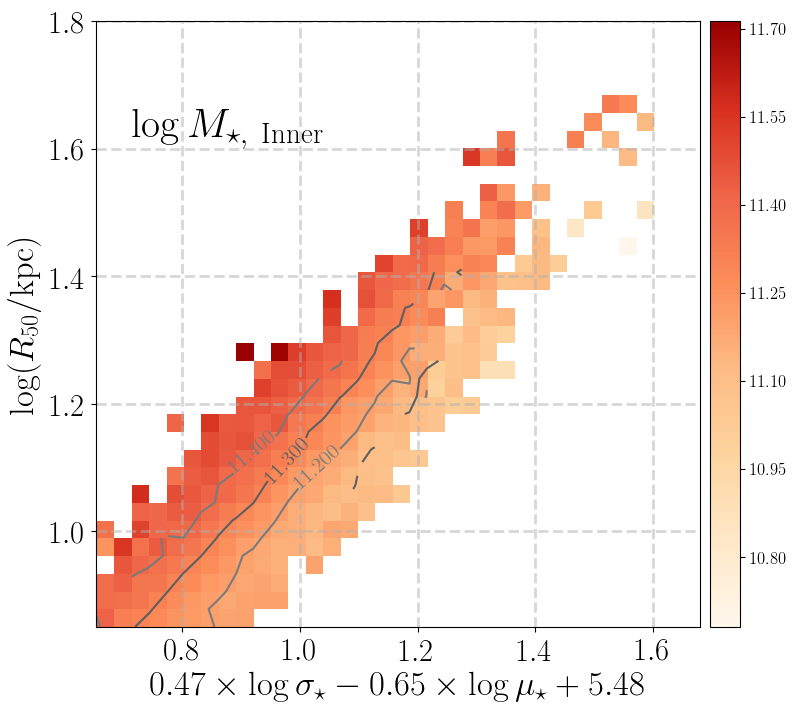

In [134]:
xx = 0.471 * logvd - 0.65 * logmu + 5.482
yy = logre
zz = np.array(obs_vdisp['logm_10'])

x_label = r'$0.47 \times \log\sigma_{\star} - 0.65 \times \log \mu_{\star} + 5.48$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.08], 
                           y_lim=[0.85, 1.8],
                           n_contour=5, scatter=False, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.2, x_title=0.06, y_title=0.8, 
                           title=r'$\log M_{\star,\ \mathrm{Inner}}$')

<IPython.core.display.Javascript object>


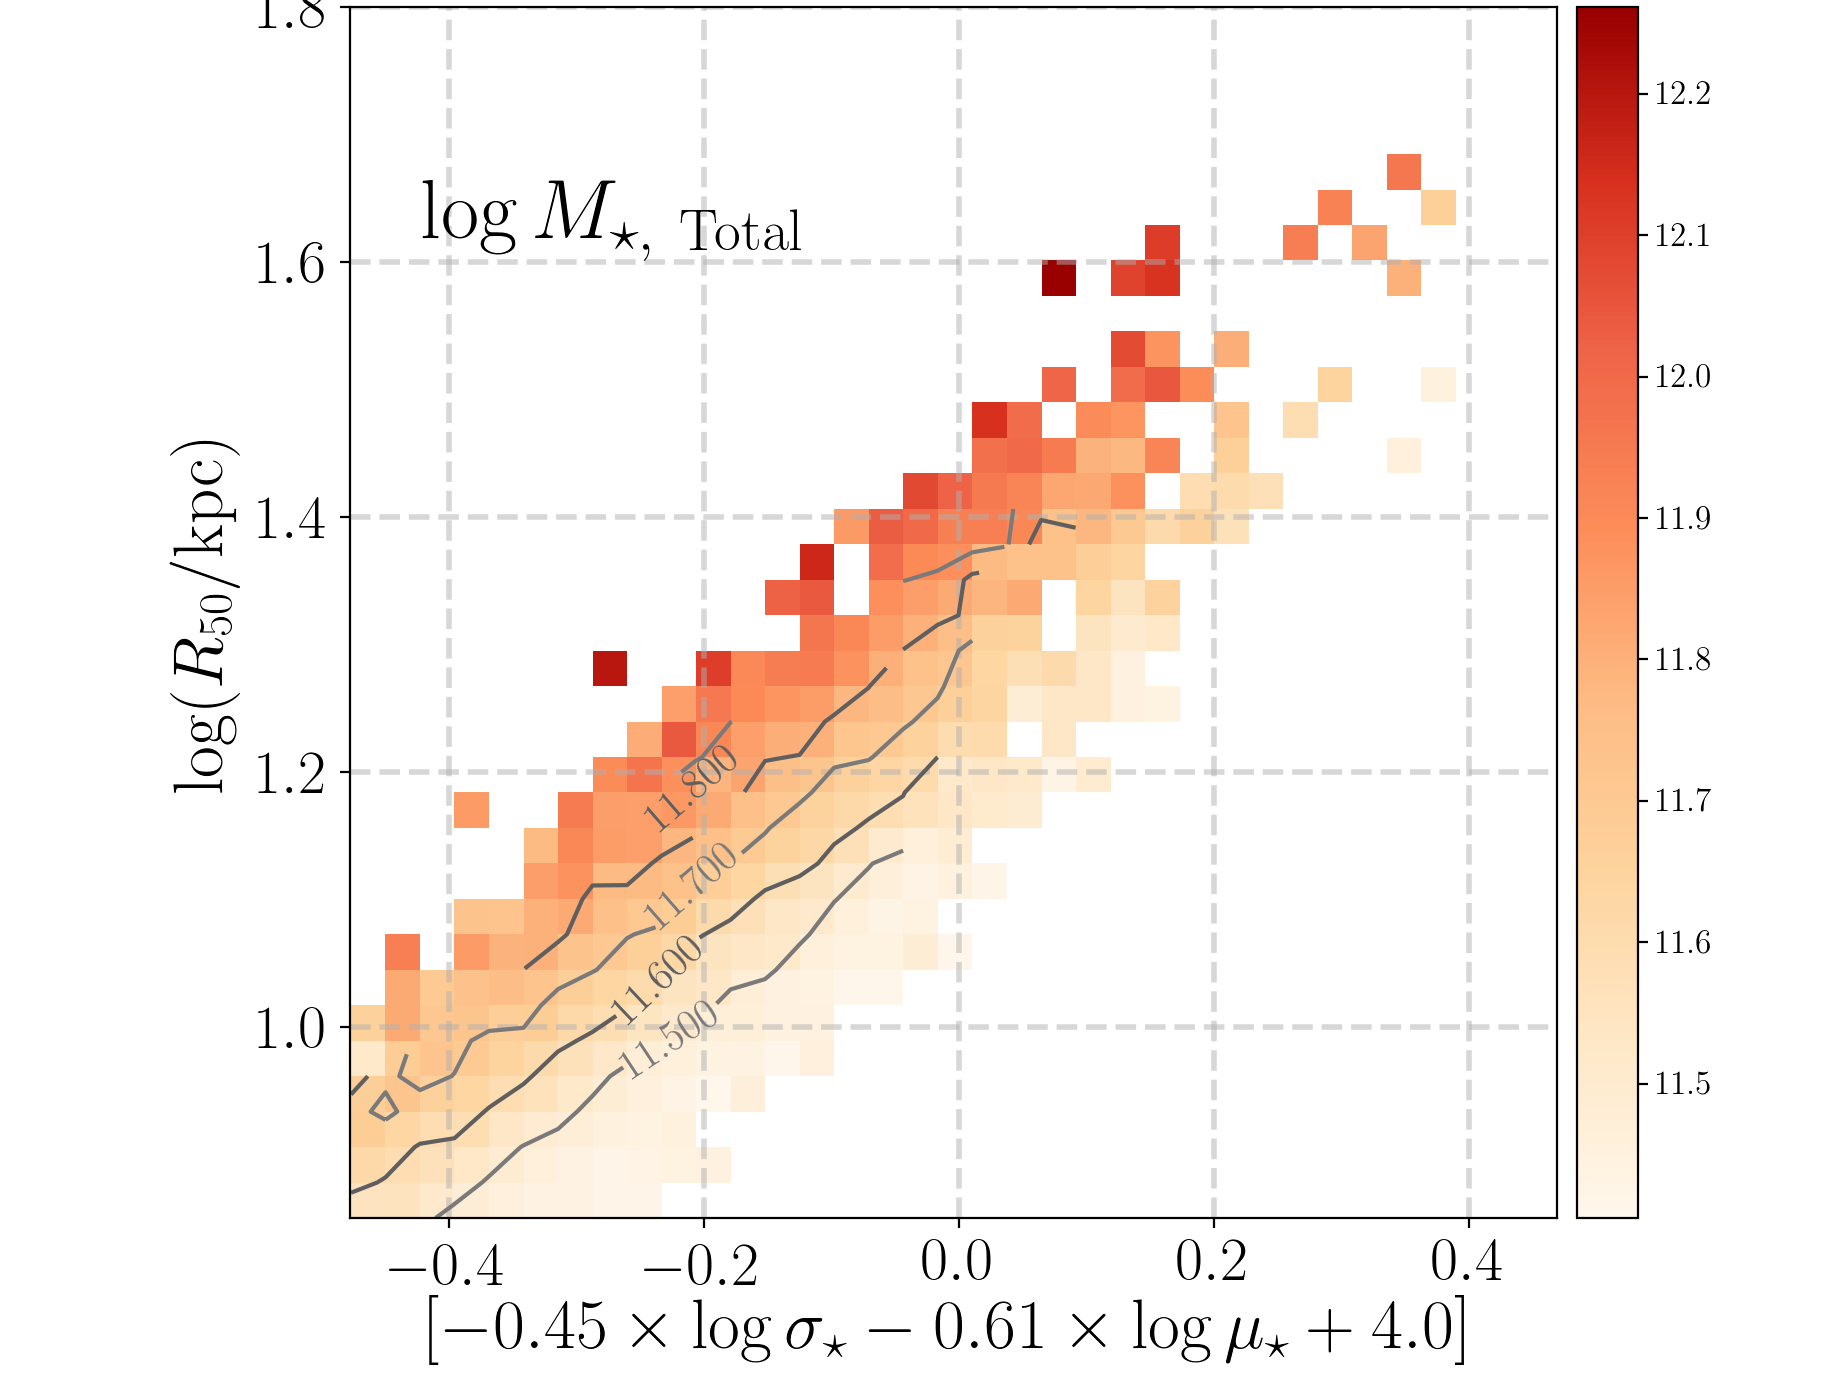

In [274]:
xx = 0.451 * logvd - 0.608 * logmu + 3.998
yy = logre
zz = np.array(obs_vdisp['logm_max'])

x_label = r'$[-0.45 \times \log\sigma_{\star} - 0.61 \times \log \mu_{\star} + 4.0]$'
y_label = r'$\log (R_{50}/\mathrm{kpc})$'


# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           x_lim=[xx.min() + 0.3, xx.max() + 0.08], 
                           y_lim=[0.85, 1.8],
                           n_contour=5, scatter=False, x_bins=32,
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.2, x_title=0.06, y_title=0.8, 
                           title=r'$\log M_{\star,\ \mathrm{Total}}$')

<IPython.core.display.Javascript object>


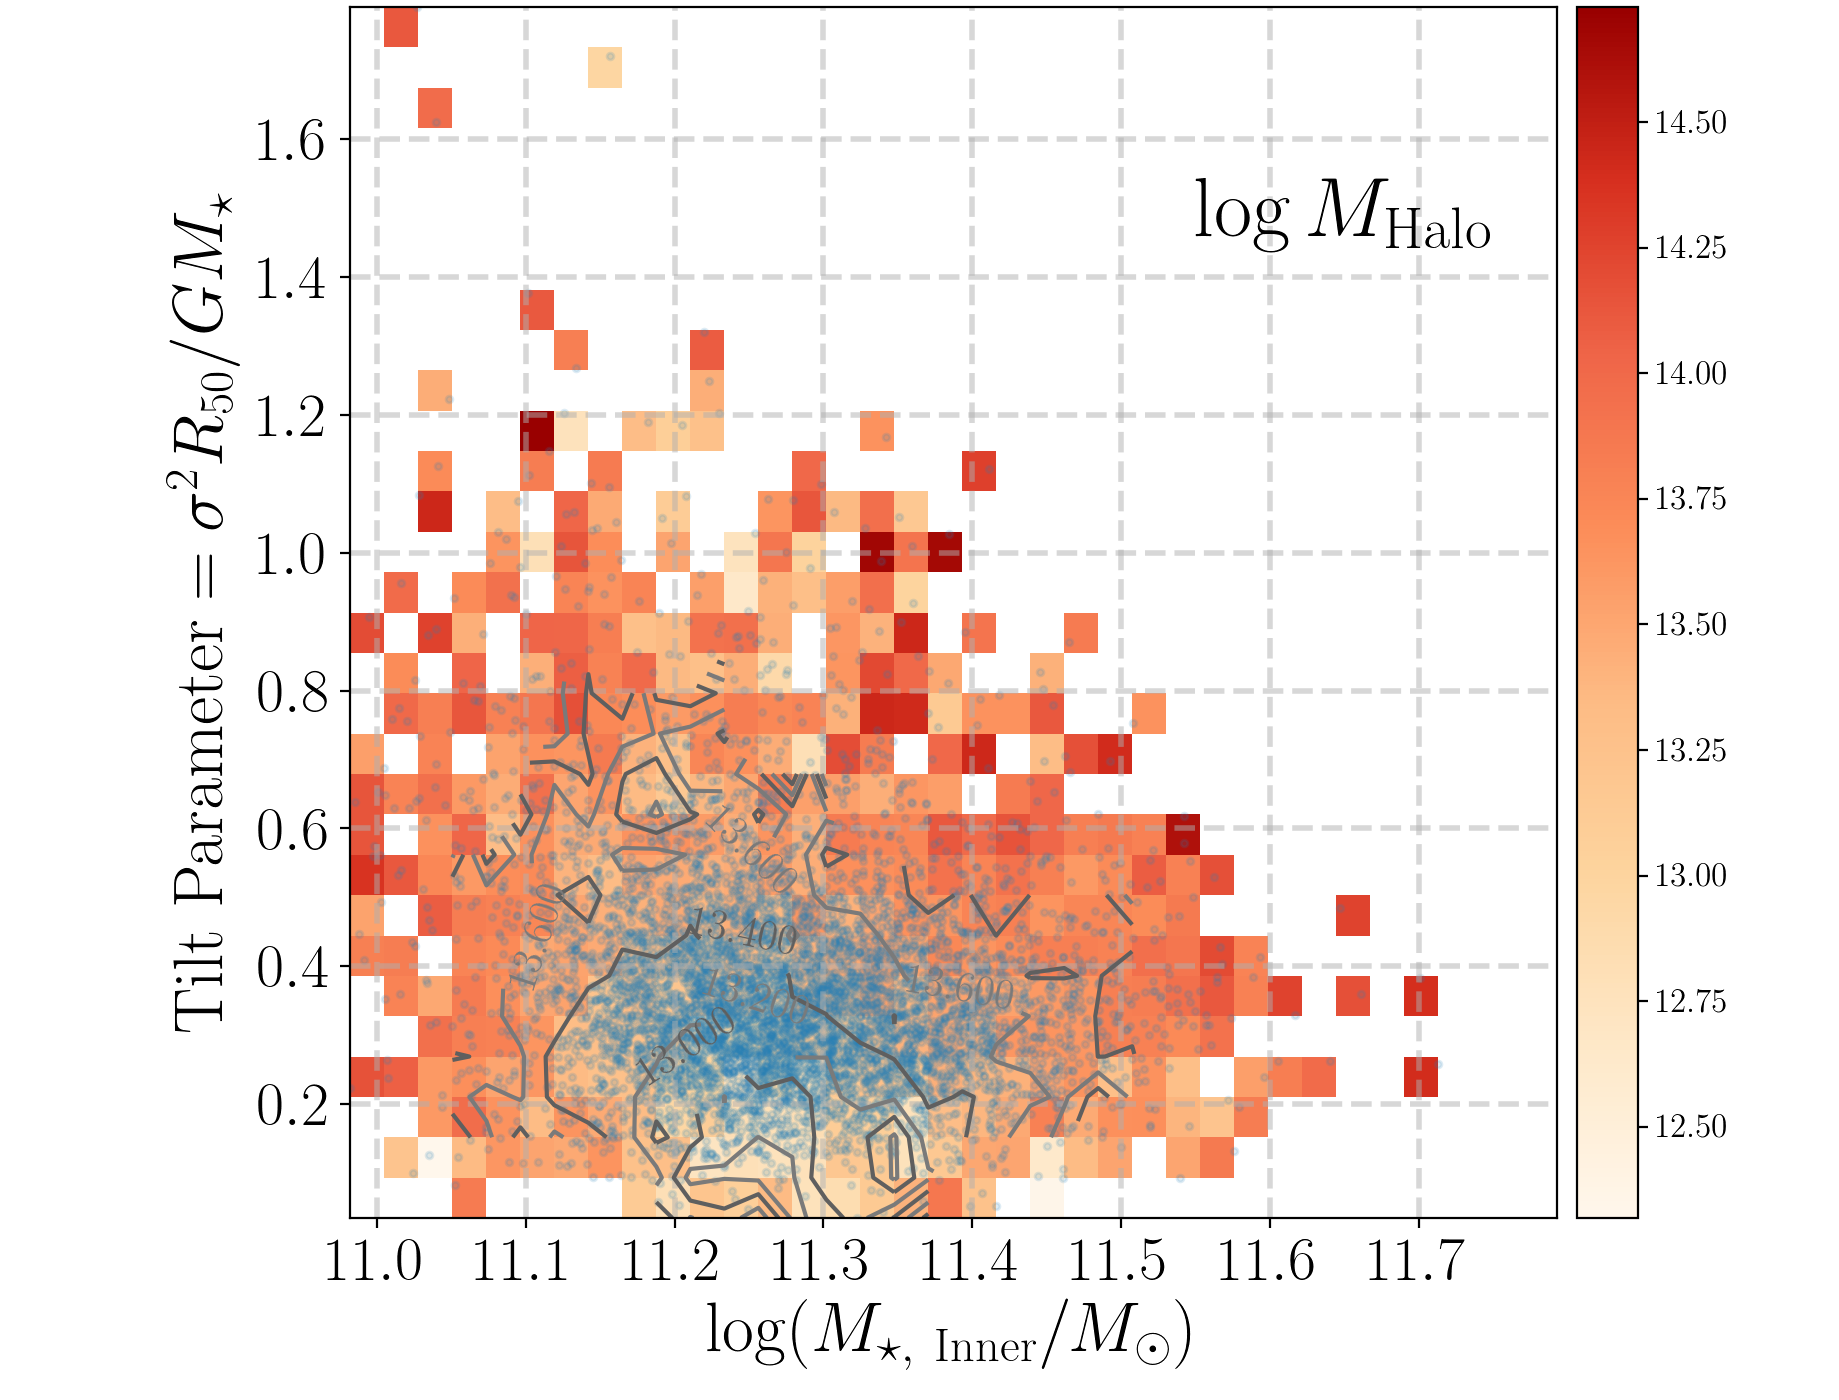

In [283]:
xx = np.array(obs_vdisp['logm_10'])
yy = 10.0 ** (2.0 * logvd + logre - logms - np.log10(4.302E-6))
zz = logmh_vir_vdisp.flatten()

x_label = r'$\log (M_{\star,\ \mathrm{Inner}}/M_{\odot})$'
y_label = r'$\mathrm{Tilt\ Parameter} =\sigma^2 R_{50} / G M_{\star}$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           n_contour=7, scatter=True, x_bins=32,
                           x_lim=[xx.min() + 0.3, xx.max() + 0.08], 
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.2, x_title=0.7, y_title=0.8, 
                           s_alpha=0.15, s_size=6)

<IPython.core.display.Javascript object>


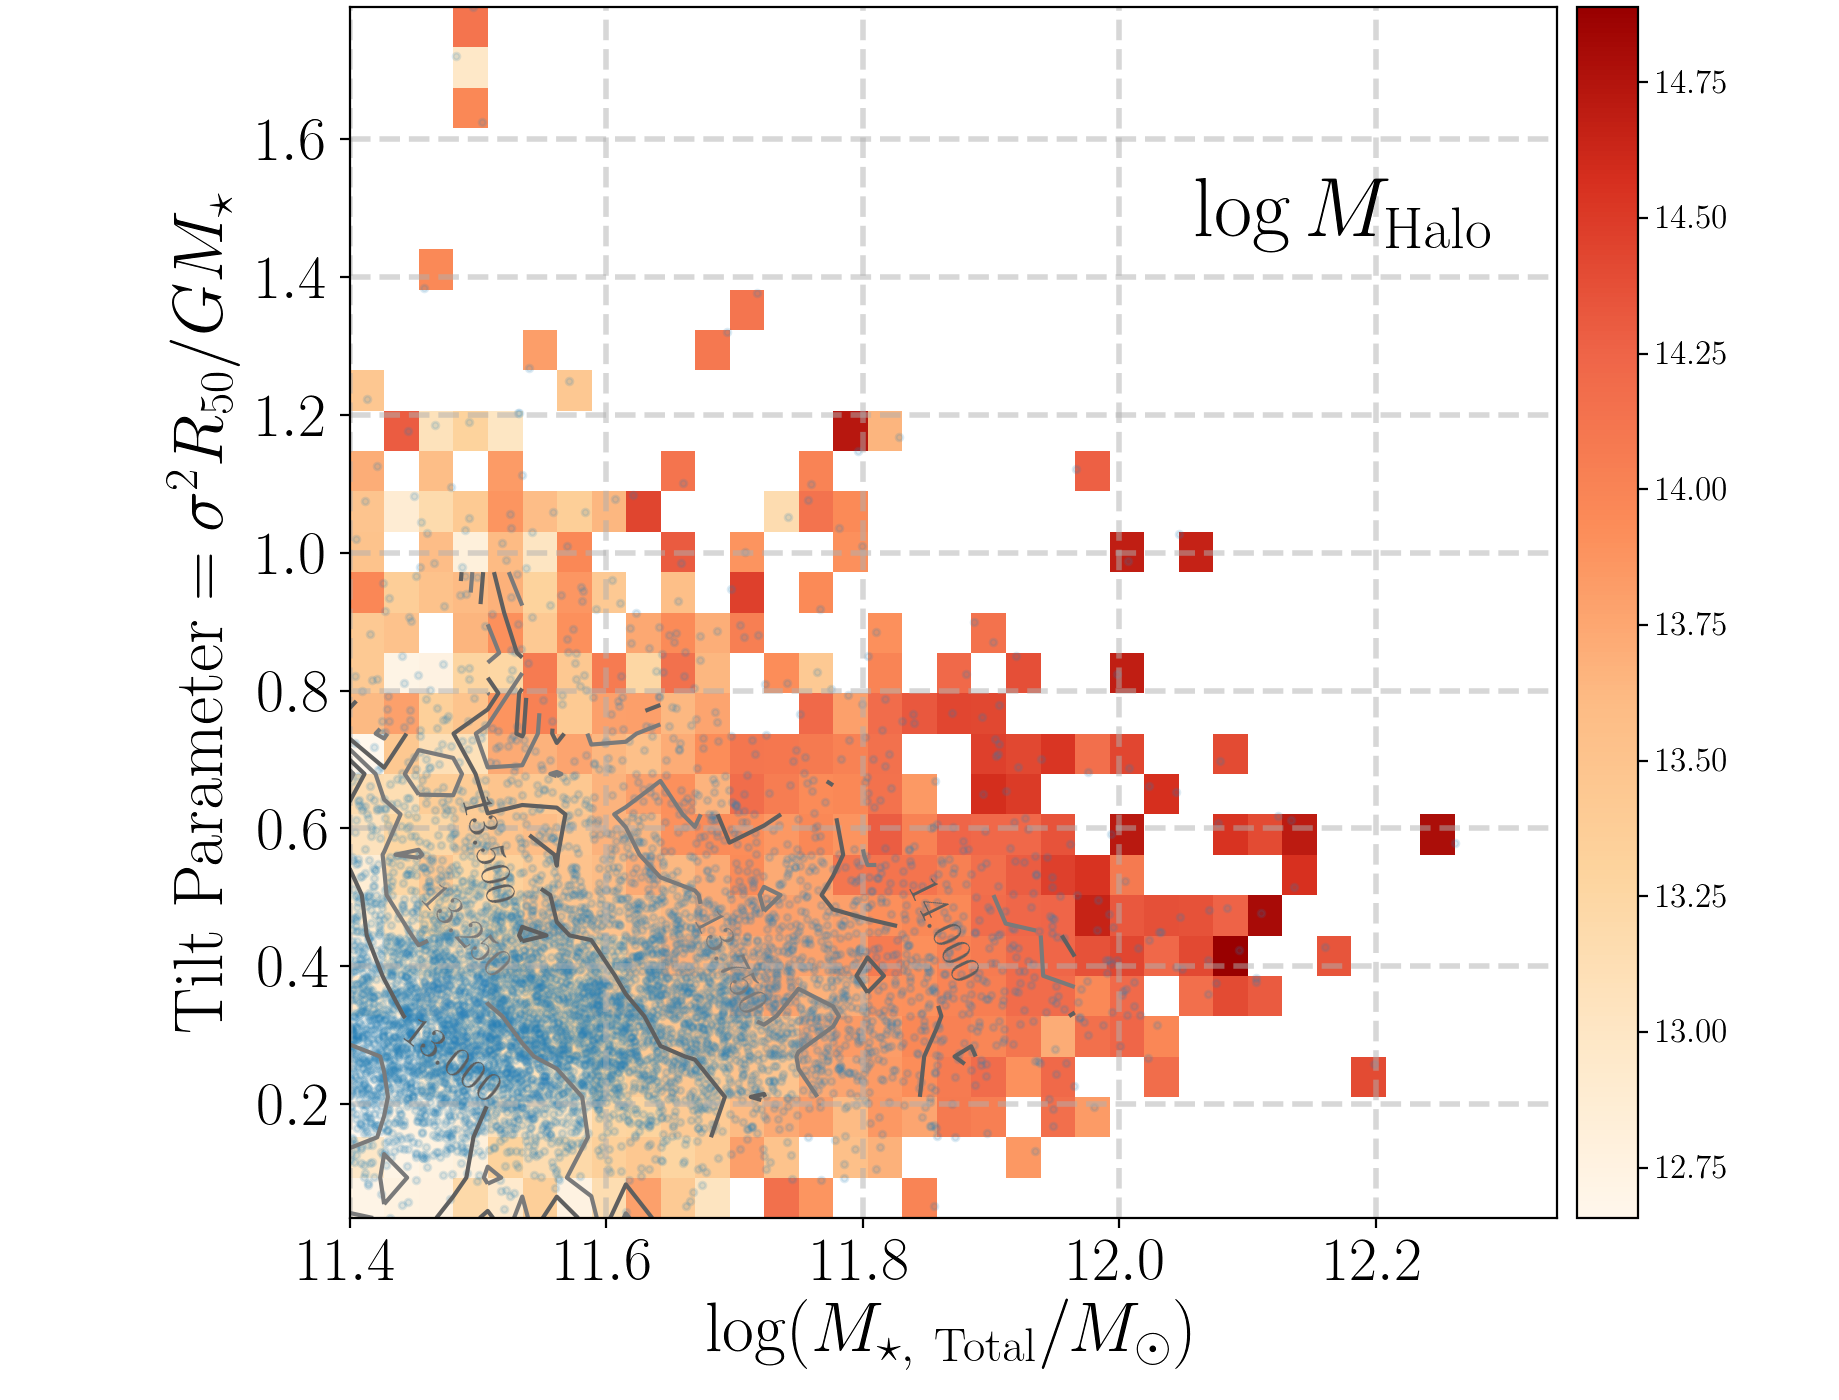

In [285]:
xx = np.array(obs_vdisp['logm_max'])
yy = 10.0 ** (2.0 * logvd + logre - logms - np.log10(4.302E-6))
zz = logmh_vir_vdisp.flatten()

x_label = r'$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$'
y_label = r'$\mathrm{Tilt\ Parameter} =\sigma^2 R_{50} / G M_{\star}$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           n_contour=7, scatter=True, x_bins=32,
                           x_lim=[xx.min() + 0.0, xx.max() + 0.08], 
                           xlabel=x_label, ylabel=y_label, 
                           gaussian=0.2, x_title=0.7, y_title=0.8, 
                           s_alpha=0.15, s_size=6)

<IPython.core.display.Javascript object>


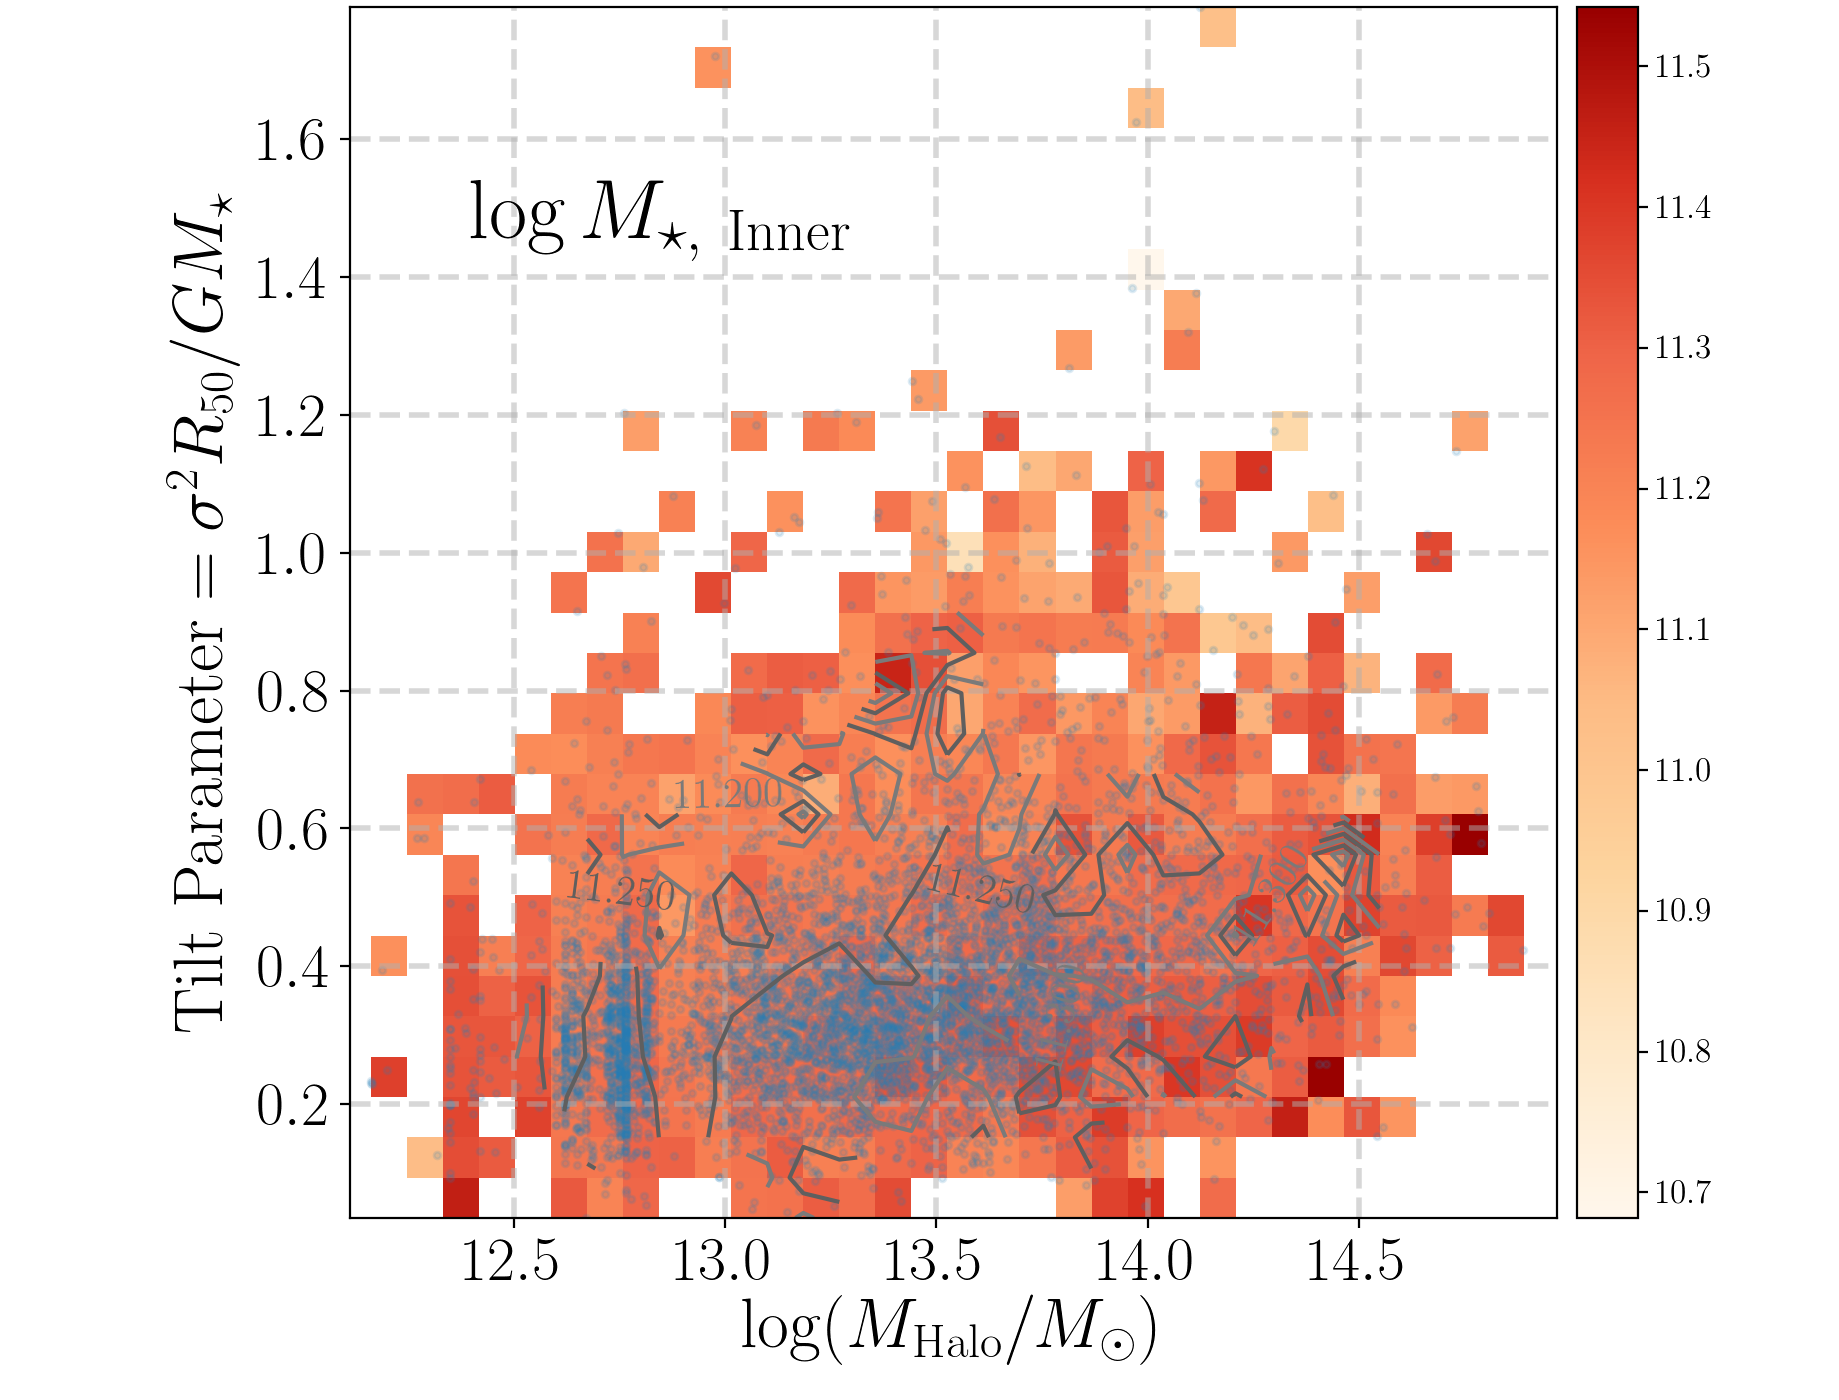

In [288]:
xx = logmh_vir_vdisp.flatten()
yy = 10.0 ** (2.0 * logvd + logre - logms - np.log10(4.302E-6))
zz = np.array(obs_vdisp['logm_10'])

x_label = r'$\log (M_{\mathrm{Halo}}/M_{\odot})$'
y_label = r'$\mathrm{Tilt\ Parameter} =\sigma^2 R_{50} / G M_{\star}$'

# Median halo mass
fig = plot_mtot_minn_trend(xx, yy, zz, method=np.median, 
                           n_contour=7, scatter=True, x_bins=32,
                           x_lim=[xx.min() + 0.5, xx.max() + 0.08], 
                           xlabel=x_label, ylabel=y_label, 
                           title=r'$\log M_{\star,\ \mathrm{Inner}}$',
                           gaussian=0.2, x_title=0.1, y_title=0.8, 
                           s_alpha=0.15, s_size=6)